In [ ]:
!pip install segmentation-models-pytorch
!pip install -U git+https://github.com/albumentations-team/albumentations
!pip install --upgrade opencv-contrib-python


[notice] A new release of pip is available: 24.0 -> 24.2
[notice] To update, run: python3.11 -m pip install --upgrade pip
  Cloning https://github.com/albumentations-team/albumentations to /private/var/folders/jg/sp0mv8pd6slgtppqwhvf1y640000gn/T/pip-req-build-_mz7k50s
  Running command git clone --filter=blob:none --quiet https://github.com/albumentations-team/albumentations /private/var/folders/jg/sp0mv8pd6slgtppqwhvf1y640000gn/T/pip-req-build-_mz7k50s
^C
ERROR: Operation cancelled by user

[notice] A new release of pip is available: 24.0 -> 24.2
[notice] To update, run: python3.11 -m pip install --upgrade pip


In [78]:
import torch
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tqdm import tqdm


In [85]:
CSV_FILE ="Human-Segmentation-Dataset-master/train.csv"
DATA_DIR = "/"
DEVICE = 'mps'

epochs = 20
lr =0.003
IMAGE_SIZE =320  ## hieght and width
BATCH_SIZE = 10

Encoder ='timm-efficientnet-b0' ## model for encoder
WEIGHTS = 'imagenet'

In [86]:
df = pd.read_csv(CSV_FILE)
df.head()

,masks,images
0,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
1,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
2,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
3,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
4,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...


In [87]:
len(df)

290

In [88]:
def show_image_data(image,mask):
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))
    print(f"image shape :{image.shape}")
    ax1.set_title('IMAGE')
    ax1.imshow(image)
    print(f"mask shape : {mask.shape}") ## mask is gray Scale
    ax2.set_title('GROUND TRUTH')
    ax2.imshow(mask,cmap  ='gray')



In [89]:
def show_image_dataset(image,mask,pred_image = None):
    if pred_image == None:
        f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))
        ax1.set_title('IMAGE')
        ax1.imshow(image.permute(1,2,0).squeeze(),cmap = 'gray')
        ax2.set_title('GROUND TRUTH')
        ax2.imshow(mask.permute(1,2,0).squeeze(),cmap = 'gray')
        
    elif pred_image != None :
    
        f, (ax1, ax2,ax3) = plt.subplots(1, 3, figsize=(10,5))
        
        ax1.set_title('IMAGE')
        ax1.imshow(image.permute(1,2,0).squeeze(),cmap = 'gray')
        
        ax2.set_title('GROUND TRUTH')
        ax2.imshow(mask.permute(1,2,0).squeeze(),cmap = 'gray')
        
        ax3.set_title('MODEL OUTPUT')
        ax3.imshow(pred_image.permute(1,2,0).squeeze(),cmap = 'gray')

In [90]:
def show_sample(df,ind):
  mask_path ,img_path = df.iloc[ind]['masks'], df.iloc[ind]['images']
  mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)/255.0
  img = cv2.imread(img_path)
  ## converting image color read bgr to rgb
  img= cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  show_image_data(img,mask)

image shape :(168, 299, 3)
mask shape : (168, 299)


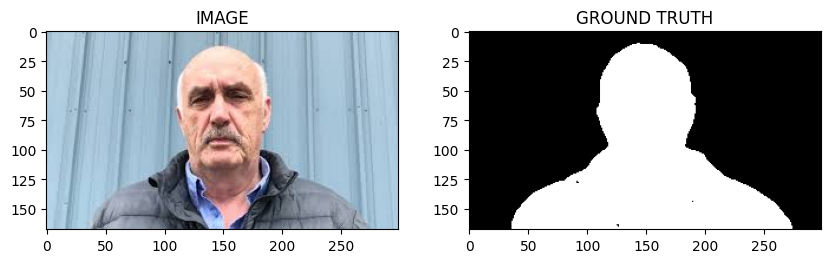

In [91]:
show_sample(df,12)

In [92]:
## Train Dataset And Validation Dataset
train_df, valid_df = train_test_split(df, test_size=0.2, random_state=41)

In [93]:
## Augmentation to increase dataset and increase variety in dataset
## we have to apply augmentation on both Image and Mask using albumentation
import albumentations as A

def get_train_augs():
    return A.Compose([
        A.Resize(IMAGE_SIZE,IMAGE_SIZE),
        A.HorizontalFlip(p=0.5),
        A.VerticalFlip(p=0.5)],is_check_shapes=False
        )

def get_valid_augs():
    return A.Compose([
        A.Resize(IMAGE_SIZE,IMAGE_SIZE),],is_check_shapes= False
    )

In [94]:
## Create Custom Dataset
from torch.utils.data import Dataset

In [95]:
class SegmentationDataset(Dataset):

    def __init__(self, df, augmentations=None):
        self.df = df
        self.augmentations =augmentations
    
    def __len__(self):
        return len(self.df)
    def __getitem__(self, index):
        
        sample = self.df.iloc[index]
        image_path = sample['images']
        mask_path = sample['masks']

        image = cv2.imread(image_path)
        image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)

        mask = cv2.imread(mask_path,cv2.IMREAD_GRAYSCALE) ## h,w only 
        mask = np.expand_dims(mask,axis =-1) ## h,w ,1

        if self.augmentations:
            data = self.augmentations(image =image,mask = mask)
            image = data['image']
            mask = data['mask']
        
        # h,w,c our image but torch accept c,h,w
        # print(f"image shape: {image.shape}")
        # print(f"mask shape: {mask.shape}")
        image  = np.transpose(image,(2,1,0)).astype(np.float32)
        mask = np.transpose(mask,(2,1,0)).astype(np.float32)

        ## normalizing pixel values 0 to 255
        image = torch.tensor(image) /255.0
        mask = torch.round(torch.tensor(mask) /255.0)  ## round labels 0 and 1

        return image, mask


    

In [96]:
train_set = SegmentationDataset(train_df,get_train_augs())
valid_set = SegmentationDataset(valid_df, get_valid_augs())

In [97]:
print(f"Train set size : {len(train_set)}")
print(f"Validation set size : {len(valid_set)}")

Train set size : 232
Validation set size : 58


In [98]:
image, mask = train_set[0]
image2, mask2 = valid_set[0]

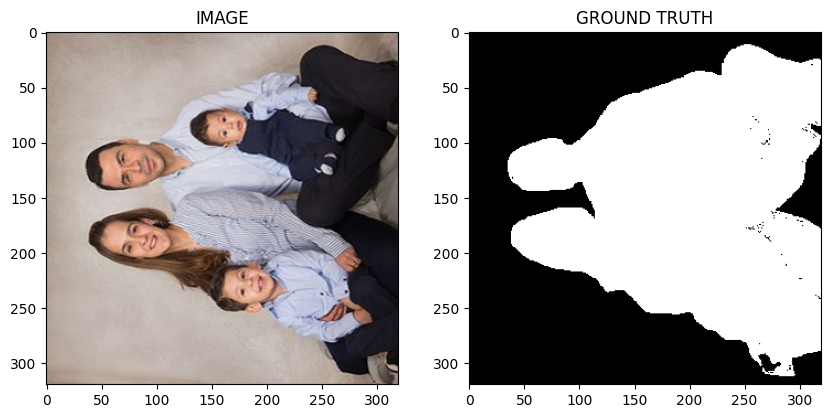

In [99]:
show_image_dataset(image2, mask2)

In [100]:
## DataLoader

In [101]:
trainloader  = DataLoader(train_set, batch_size=BATCH_SIZE,shuffle=True)
validloader = DataLoader(valid_set, batch_size=BATCH_SIZE)

In [102]:
len(validloader)

6

In [103]:
print(f"Batches in Train loader : {len(trainloader)}")
print(f"Batches in Valid loader :{len(validloader)}")

Batches in Train loader : 24
Batches in Valid loader :6


In [104]:
for image, mask in trainloader:
    print(f"image shape : {image.shape}")
    print(f"mask shape : {mask.shape}")
    break
    

image shape : torch.Size([10, 3, 320, 320])
mask shape : torch.Size([10, 1, 320, 320])


In [105]:
## Segmnetation Model
import segmentation_models_pytorch as smp
from segmentation_models_pytorch.losses import DiceLoss

In [106]:
import torch.nn as nn
class SegmentationModel(nn.Module):
    def __init__(self):
        super(SegmentationModel,self).__init__()

        self.architercture = smp.Unet(
            encoder_name = Encoder,
            encoder_weights =  WEIGHTS,
            in_channels =3 ,# as our images are rgb
            classes =1,
            activation = None)
    
    def forward(self, image, mask = None):
        logits = self.architercture(image)
        if mask != None:
            loss1 = DiceLoss(mode='binary')(logits, mask)
            loss2 = nn.BCEWithLogitsLoss()(logits,mask)
            return logits , (loss1 + loss2)


        return logits

In [107]:
## Create Train And Validation Function
model = SegmentationModel()
model.to(DEVICE)

SegmentationModel(
  (architercture): Unet(
    (encoder): EfficientNetEncoder(
      (conv_stem): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (bn1): BatchNormAct2d(
        32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
        (drop): Identity()
        (act): Swish()
      )
      (blocks): Sequential(
        (0): Sequential(
          (0): DepthwiseSeparableConv(
            (conv_dw): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (bn1): BatchNormAct2d(
              32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
              (drop): Identity()
              (act): Swish()
            )
            (se): SqueezeExcite(
              (conv_reduce): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
              (act1): Swish()
              (conv_expand): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
              (gate): Sigmoid()
            )
 

## Create Train And Validation Function

In [108]:
def train_fn(data_loader, model,optimizer):
    model.train()
    total_loss = 0
    for images, masks in tqdm(data_loader):
        images = images.to(DEVICE)
        masks = masks.to(DEVICE)

        optimizer.zero_grad() # gradient zero

        logits, loss = model(images,masks) ## forward prop
        print(f"Logits shape: {logits.shape}, Masks shape: {masks.shape}")  
        loss.backward() ## backward prop
        optimizer.step() ## weights update
        total_loss +=loss.item()

    return total_loss/len(data_loader)

def eval_fn(data_loader,model):
    model.eval()
    total_loss = 0
    with torch.no_grad():
        for images, masks in tqdm(data_loader):
            images = images.to(DEVICE)
            masks = masks.to(DEVICE)

            logits, loss = model(images,masks) ## forward prop
            total_loss +=loss.item()

    return total_loss/len(data_loader)

        

In [109]:
## Taining Loop
optimizer  = torch.optim.Adam(model.parameters(),lr =lr)

best_valid_loss = np.Inf
for epoch in range(epochs):
    train_loss = train_fn(trainloader,model,optimizer)
    valid_loss = eval_fn(validloader,model)

    if valid_loss < best_valid_loss:
        torch.save(model.state_dict(),'best_segmentation_model.pt')
        best_valid_loss = valid_loss
    
    print(f"EPOCH :{epoch+1}  Train loss : {train_loss} Valid loss: {valid_loss}")



  0%|          | 0/24 [00:00<?, ?it/s]

Logits shape: torch.Size([10, 1, 320, 320]), Masks shape: torch.Size([10, 1, 320, 320])


  4%|▍         | 1/24 [00:17<06:30, 16.97s/it]

Logits shape: torch.Size([10, 1, 320, 320]), Masks shape: torch.Size([10, 1, 320, 320])


  8%|▊         | 2/24 [01:18<15:47, 43.07s/it]

Logits shape: torch.Size([10, 1, 320, 320]), Masks shape: torch.Size([10, 1, 320, 320])


 12%|█▎        | 3/24 [01:58<14:39, 41.90s/it]

Logits shape: torch.Size([10, 1, 320, 320]), Masks shape: torch.Size([10, 1, 320, 320])


 17%|█▋        | 4/24 [02:25<11:58, 35.91s/it]

Logits shape: torch.Size([10, 1, 320, 320]), Masks shape: torch.Size([10, 1, 320, 320])


 21%|██        | 5/24 [02:50<10:04, 31.82s/it]

Logits shape: torch.Size([10, 1, 320, 320]), Masks shape: torch.Size([10, 1, 320, 320])


 25%|██▌       | 6/24 [03:34<10:48, 36.01s/it]

Logits shape: torch.Size([10, 1, 320, 320]), Masks shape: torch.Size([10, 1, 320, 320])


 29%|██▉       | 7/24 [04:22<11:17, 39.85s/it]

Logits shape: torch.Size([10, 1, 320, 320]), Masks shape: torch.Size([10, 1, 320, 320])


 33%|███▎      | 8/24 [04:55<10:05, 37.86s/it]

Logits shape: torch.Size([10, 1, 320, 320]), Masks shape: torch.Size([10, 1, 320, 320])


 38%|███▊      | 9/24 [05:18<08:18, 33.22s/it]

Logits shape: torch.Size([10, 1, 320, 320]), Masks shape: torch.Size([10, 1, 320, 320])


 42%|████▏     | 10/24 [06:19<09:43, 41.67s/it]

Logits shape: torch.Size([10, 1, 320, 320]), Masks shape: torch.Size([10, 1, 320, 320])


 46%|████▌     | 11/24 [07:04<09:17, 42.86s/it]

Logits shape: torch.Size([10, 1, 320, 320]), Masks shape: torch.Size([10, 1, 320, 320])


 50%|█████     | 12/24 [08:28<11:03, 55.33s/it]

Logits shape: torch.Size([10, 1, 320, 320]), Masks shape: torch.Size([10, 1, 320, 320])


 54%|█████▍    | 13/24 [09:23<10:08, 55.30s/it]

Logits shape: torch.Size([10, 1, 320, 320]), Masks shape: torch.Size([10, 1, 320, 320])


 58%|█████▊    | 14/24 [09:47<07:36, 45.64s/it]

Logits shape: torch.Size([10, 1, 320, 320]), Masks shape: torch.Size([10, 1, 320, 320])


 62%|██████▎   | 15/24 [09:56<05:12, 34.77s/it]

Logits shape: torch.Size([10, 1, 320, 320]), Masks shape: torch.Size([10, 1, 320, 320])


 67%|██████▋   | 16/24 [10:21<04:13, 31.65s/it]

Logits shape: torch.Size([10, 1, 320, 320]), Masks shape: torch.Size([10, 1, 320, 320])


 71%|███████   | 17/24 [11:10<04:19, 37.04s/it]

Logits shape: torch.Size([10, 1, 320, 320]), Masks shape: torch.Size([10, 1, 320, 320])


 75%|███████▌  | 18/24 [11:56<03:57, 39.63s/it]

Logits shape: torch.Size([10, 1, 320, 320]), Masks shape: torch.Size([10, 1, 320, 320])


 79%|███████▉  | 19/24 [12:12<02:42, 32.43s/it]

Logits shape: torch.Size([10, 1, 320, 320]), Masks shape: torch.Size([10, 1, 320, 320])


 83%|████████▎ | 20/24 [12:39<02:04, 31.05s/it]

Logits shape: torch.Size([10, 1, 320, 320]), Masks shape: torch.Size([10, 1, 320, 320])


 88%|████████▊ | 21/24 [12:44<01:09, 23.25s/it]

Logits shape: torch.Size([10, 1, 320, 320]), Masks shape: torch.Size([10, 1, 320, 320])


 92%|█████████▏| 22/24 [13:09<00:47, 23.51s/it]

Logits shape: torch.Size([10, 1, 320, 320]), Masks shape: torch.Size([10, 1, 320, 320])


 96%|█████████▌| 23/24 [13:12<00:17, 17.58s/it]

Logits shape: torch.Size([2, 1, 320, 320]), Masks shape: torch.Size([2, 1, 320, 320])


100%|██████████| 6/6 [00:03<00:00,  1.81it/s]


EPOCH :1  Train loss : 0.7291045561432838 Valid loss: 0.9422064125537872


  0%|          | 0/24 [00:00<?, ?it/s]

Logits shape: torch.Size([10, 1, 320, 320]), Masks shape: torch.Size([10, 1, 320, 320])


  4%|▍         | 1/24 [00:07<02:55,  7.64s/it]

Logits shape: torch.Size([10, 1, 320, 320]), Masks shape: torch.Size([10, 1, 320, 320])


  8%|▊         | 2/24 [00:16<03:01,  8.27s/it]

Logits shape: torch.Size([10, 1, 320, 320]), Masks shape: torch.Size([10, 1, 320, 320])


 12%|█▎        | 3/24 [00:26<03:11,  9.13s/it]

Logits shape: torch.Size([10, 1, 320, 320]), Masks shape: torch.Size([10, 1, 320, 320])


 17%|█▋        | 4/24 [00:35<03:00,  9.04s/it]

Logits shape: torch.Size([10, 1, 320, 320]), Masks shape: torch.Size([10, 1, 320, 320])


 21%|██        | 5/24 [00:43<02:45,  8.72s/it]

Logits shape: torch.Size([10, 1, 320, 320]), Masks shape: torch.Size([10, 1, 320, 320])


 25%|██▌       | 6/24 [00:49<02:17,  7.67s/it]

Logits shape: torch.Size([10, 1, 320, 320]), Masks shape: torch.Size([10, 1, 320, 320])


 29%|██▉       | 7/24 [00:53<01:48,  6.41s/it]

Logits shape: torch.Size([10, 1, 320, 320]), Masks shape: torch.Size([10, 1, 320, 320])


 33%|███▎      | 8/24 [01:01<01:53,  7.07s/it]

Logits shape: torch.Size([10, 1, 320, 320]), Masks shape: torch.Size([10, 1, 320, 320])


 38%|███▊      | 9/24 [01:03<01:23,  5.59s/it]

Logits shape: torch.Size([10, 1, 320, 320]), Masks shape: torch.Size([10, 1, 320, 320])


 42%|████▏     | 10/24 [01:09<01:17,  5.54s/it]

Logits shape: torch.Size([10, 1, 320, 320]), Masks shape: torch.Size([10, 1, 320, 320])


 46%|████▌     | 11/24 [01:24<01:51,  8.61s/it]

Logits shape: torch.Size([10, 1, 320, 320]), Masks shape: torch.Size([10, 1, 320, 320])


 50%|█████     | 12/24 [01:30<01:30,  7.58s/it]

Logits shape: torch.Size([10, 1, 320, 320]), Masks shape: torch.Size([10, 1, 320, 320])


 54%|█████▍    | 13/24 [01:32<01:07,  6.09s/it]

Logits shape: torch.Size([10, 1, 320, 320]), Masks shape: torch.Size([10, 1, 320, 320])


 58%|█████▊    | 14/24 [01:44<01:17,  7.73s/it]

Logits shape: torch.Size([10, 1, 320, 320]), Masks shape: torch.Size([10, 1, 320, 320])


 62%|██████▎   | 15/24 [01:54<01:16,  8.55s/it]

Logits shape: torch.Size([10, 1, 320, 320]), Masks shape: torch.Size([10, 1, 320, 320])


 67%|██████▋   | 16/24 [01:57<00:54,  6.76s/it]

Logits shape: torch.Size([10, 1, 320, 320]), Masks shape: torch.Size([10, 1, 320, 320])


 71%|███████   | 17/24 [02:09<00:57,  8.27s/it]

Logits shape: torch.Size([10, 1, 320, 320]), Masks shape: torch.Size([10, 1, 320, 320])


 75%|███████▌  | 18/24 [02:20<00:54,  9.12s/it]

Logits shape: torch.Size([10, 1, 320, 320]), Masks shape: torch.Size([10, 1, 320, 320])


 79%|███████▉  | 19/24 [02:37<00:58, 11.68s/it]

Logits shape: torch.Size([10, 1, 320, 320]), Masks shape: torch.Size([10, 1, 320, 320])


 83%|████████▎ | 20/24 [02:45<00:42, 10.63s/it]

Logits shape: torch.Size([10, 1, 320, 320]), Masks shape: torch.Size([10, 1, 320, 320])


 88%|████████▊ | 21/24 [02:49<00:25,  8.60s/it]

Logits shape: torch.Size([10, 1, 320, 320]), Masks shape: torch.Size([10, 1, 320, 320])


 92%|█████████▏| 22/24 [02:52<00:13,  6.67s/it]

Logits shape: torch.Size([10, 1, 320, 320]), Masks shape: torch.Size([10, 1, 320, 320])


 96%|█████████▌| 23/24 [02:56<00:05,  5.92s/it]

Logits shape: torch.Size([2, 1, 320, 320]), Masks shape: torch.Size([2, 1, 320, 320])


100%|██████████| 6/6 [00:04<00:00,  1.41it/s]


EPOCH :2  Train loss : 0.4472307674586773 Valid loss: 0.5185201466083527


  0%|          | 0/24 [00:00<?, ?it/s]

Logits shape: torch.Size([10, 1, 320, 320]), Masks shape: torch.Size([10, 1, 320, 320])


  4%|▍         | 1/24 [00:10<04:07, 10.77s/it]

Logits shape: torch.Size([10, 1, 320, 320]), Masks shape: torch.Size([10, 1, 320, 320])


  8%|▊         | 2/24 [00:14<02:20,  6.37s/it]

Logits shape: torch.Size([10, 1, 320, 320]), Masks shape: torch.Size([10, 1, 320, 320])


 12%|█▎        | 3/24 [00:16<01:36,  4.62s/it]

Logits shape: torch.Size([10, 1, 320, 320]), Masks shape: torch.Size([10, 1, 320, 320])


 17%|█▋        | 4/24 [00:19<01:17,  3.90s/it]

Logits shape: torch.Size([10, 1, 320, 320]), Masks shape: torch.Size([10, 1, 320, 320])


 21%|██        | 5/24 [00:21<01:03,  3.36s/it]

Logits shape: torch.Size([10, 1, 320, 320]), Masks shape: torch.Size([10, 1, 320, 320])


 25%|██▌       | 6/24 [00:24<00:54,  3.01s/it]

Logits shape: torch.Size([10, 1, 320, 320]), Masks shape: torch.Size([10, 1, 320, 320])


 29%|██▉       | 7/24 [00:26<00:48,  2.84s/it]

Logits shape: torch.Size([10, 1, 320, 320]), Masks shape: torch.Size([10, 1, 320, 320])


 33%|███▎      | 8/24 [00:30<00:49,  3.10s/it]

Logits shape: torch.Size([10, 1, 320, 320]), Masks shape: torch.Size([10, 1, 320, 320])


 38%|███▊      | 9/24 [00:52<02:16,  9.08s/it]

Logits shape: torch.Size([10, 1, 320, 320]), Masks shape: torch.Size([10, 1, 320, 320])


 42%|████▏     | 10/24 [00:55<01:42,  7.33s/it]

Logits shape: torch.Size([10, 1, 320, 320]), Masks shape: torch.Size([10, 1, 320, 320])


 46%|████▌     | 11/24 [01:01<01:29,  6.90s/it]

Logits shape: torch.Size([10, 1, 320, 320]), Masks shape: torch.Size([10, 1, 320, 320])


 50%|█████     | 12/24 [01:08<01:20,  6.68s/it]

Logits shape: torch.Size([10, 1, 320, 320]), Masks shape: torch.Size([10, 1, 320, 320])


 54%|█████▍    | 13/24 [01:28<01:59, 10.86s/it]

Logits shape: torch.Size([10, 1, 320, 320]), Masks shape: torch.Size([10, 1, 320, 320])


 58%|█████▊    | 14/24 [01:41<01:54, 11.49s/it]

Logits shape: torch.Size([10, 1, 320, 320]), Masks shape: torch.Size([10, 1, 320, 320])


 62%|██████▎   | 15/24 [01:48<01:31, 10.22s/it]

Logits shape: torch.Size([10, 1, 320, 320]), Masks shape: torch.Size([10, 1, 320, 320])


 67%|██████▋   | 16/24 [01:51<01:04,  8.11s/it]

Logits shape: torch.Size([10, 1, 320, 320]), Masks shape: torch.Size([10, 1, 320, 320])


 71%|███████   | 17/24 [01:53<00:44,  6.29s/it]

Logits shape: torch.Size([10, 1, 320, 320]), Masks shape: torch.Size([10, 1, 320, 320])


 75%|███████▌  | 18/24 [01:57<00:33,  5.59s/it]

Logits shape: torch.Size([10, 1, 320, 320]), Masks shape: torch.Size([10, 1, 320, 320])


 79%|███████▉  | 19/24 [02:00<00:23,  4.61s/it]

Logits shape: torch.Size([10, 1, 320, 320]), Masks shape: torch.Size([10, 1, 320, 320])


 83%|████████▎ | 20/24 [02:02<00:15,  3.90s/it]

Logits shape: torch.Size([10, 1, 320, 320]), Masks shape: torch.Size([10, 1, 320, 320])


 88%|████████▊ | 21/24 [02:04<00:10,  3.36s/it]

Logits shape: torch.Size([10, 1, 320, 320]), Masks shape: torch.Size([10, 1, 320, 320])


 92%|█████████▏| 22/24 [02:06<00:05,  2.87s/it]

Logits shape: torch.Size([10, 1, 320, 320]), Masks shape: torch.Size([10, 1, 320, 320])


 96%|█████████▌| 23/24 [02:08<00:02,  2.77s/it]

Logits shape: torch.Size([2, 1, 320, 320]), Masks shape: torch.Size([2, 1, 320, 320])


100%|██████████| 6/6 [00:01<00:00,  3.26it/s]


EPOCH :3  Train loss : 0.4061693213880062 Valid loss: 0.49452262620131177


  0%|          | 0/24 [00:00<?, ?it/s]

Logits shape: torch.Size([10, 1, 320, 320]), Masks shape: torch.Size([10, 1, 320, 320])


  4%|▍         | 1/24 [00:02<00:55,  2.43s/it]

Logits shape: torch.Size([10, 1, 320, 320]), Masks shape: torch.Size([10, 1, 320, 320])


  8%|▊         | 2/24 [00:07<01:26,  3.95s/it]

Logits shape: torch.Size([10, 1, 320, 320]), Masks shape: torch.Size([10, 1, 320, 320])


 12%|█▎        | 3/24 [00:10<01:09,  3.31s/it]

Logits shape: torch.Size([10, 1, 320, 320]), Masks shape: torch.Size([10, 1, 320, 320])


 17%|█▋        | 4/24 [00:12<01:03,  3.18s/it]

Logits shape: torch.Size([10, 1, 320, 320]), Masks shape: torch.Size([10, 1, 320, 320])


 21%|██        | 5/24 [00:17<01:06,  3.51s/it]

Logits shape: torch.Size([10, 1, 320, 320]), Masks shape: torch.Size([10, 1, 320, 320])


 25%|██▌       | 6/24 [00:19<00:57,  3.22s/it]

Logits shape: torch.Size([10, 1, 320, 320]), Masks shape: torch.Size([10, 1, 320, 320])


 29%|██▉       | 7/24 [00:22<00:51,  3.00s/it]

Logits shape: torch.Size([10, 1, 320, 320]), Masks shape: torch.Size([10, 1, 320, 320])


 33%|███▎      | 8/24 [00:24<00:43,  2.69s/it]

Logits shape: torch.Size([10, 1, 320, 320]), Masks shape: torch.Size([10, 1, 320, 320])


 38%|███▊      | 9/24 [00:27<00:44,  2.97s/it]

Logits shape: torch.Size([10, 1, 320, 320]), Masks shape: torch.Size([10, 1, 320, 320])


 42%|████▏     | 10/24 [00:30<00:41,  2.96s/it]

Logits shape: torch.Size([10, 1, 320, 320]), Masks shape: torch.Size([10, 1, 320, 320])


 46%|████▌     | 11/24 [00:33<00:38,  2.99s/it]

Logits shape: torch.Size([10, 1, 320, 320]), Masks shape: torch.Size([10, 1, 320, 320])


 50%|█████     | 12/24 [00:40<00:50,  4.17s/it]

Logits shape: torch.Size([10, 1, 320, 320]), Masks shape: torch.Size([10, 1, 320, 320])


 54%|█████▍    | 13/24 [00:45<00:46,  4.21s/it]

Logits shape: torch.Size([10, 1, 320, 320]), Masks shape: torch.Size([10, 1, 320, 320])


 58%|█████▊    | 14/24 [00:48<00:38,  3.85s/it]

Logits shape: torch.Size([10, 1, 320, 320]), Masks shape: torch.Size([10, 1, 320, 320])


 62%|██████▎   | 15/24 [00:54<00:41,  4.66s/it]

Logits shape: torch.Size([10, 1, 320, 320]), Masks shape: torch.Size([10, 1, 320, 320])


 67%|██████▋   | 16/24 [01:07<00:57,  7.18s/it]

Logits shape: torch.Size([10, 1, 320, 320]), Masks shape: torch.Size([10, 1, 320, 320])


 71%|███████   | 17/24 [01:10<00:40,  5.78s/it]

Logits shape: torch.Size([10, 1, 320, 320]), Masks shape: torch.Size([10, 1, 320, 320])


 75%|███████▌  | 18/24 [01:11<00:27,  4.58s/it]

Logits shape: torch.Size([10, 1, 320, 320]), Masks shape: torch.Size([10, 1, 320, 320])


 79%|███████▉  | 19/24 [01:19<00:27,  5.43s/it]

Logits shape: torch.Size([10, 1, 320, 320]), Masks shape: torch.Size([10, 1, 320, 320])


 83%|████████▎ | 20/24 [01:22<00:19,  4.77s/it]

Logits shape: torch.Size([10, 1, 320, 320]), Masks shape: torch.Size([10, 1, 320, 320])


 88%|████████▊ | 21/24 [01:24<00:11,  3.91s/it]

Logits shape: torch.Size([10, 1, 320, 320]), Masks shape: torch.Size([10, 1, 320, 320])


 92%|█████████▏| 22/24 [01:26<00:06,  3.33s/it]

Logits shape: torch.Size([10, 1, 320, 320]), Masks shape: torch.Size([10, 1, 320, 320])


 96%|█████████▌| 23/24 [01:36<00:05,  5.30s/it]

Logits shape: torch.Size([2, 1, 320, 320]), Masks shape: torch.Size([2, 1, 320, 320])


100%|██████████| 6/6 [00:08<00:00,  1.41s/it]


EPOCH :4  Train loss : 0.33522270309428376 Valid loss: 0.24916629244883856


  0%|          | 0/24 [00:00<?, ?it/s]

Logits shape: torch.Size([10, 1, 320, 320]), Masks shape: torch.Size([10, 1, 320, 320])


  4%|▍         | 1/24 [00:07<02:49,  7.37s/it]

Logits shape: torch.Size([10, 1, 320, 320]), Masks shape: torch.Size([10, 1, 320, 320])


  8%|▊         | 2/24 [00:11<02:02,  5.57s/it]

Logits shape: torch.Size([10, 1, 320, 320]), Masks shape: torch.Size([10, 1, 320, 320])


 12%|█▎        | 3/24 [00:28<03:41, 10.54s/it]

Logits shape: torch.Size([10, 1, 320, 320]), Masks shape: torch.Size([10, 1, 320, 320])


 17%|█▋        | 4/24 [00:31<02:33,  7.66s/it]

Logits shape: torch.Size([10, 1, 320, 320]), Masks shape: torch.Size([10, 1, 320, 320])


 21%|██        | 5/24 [00:36<02:08,  6.77s/it]

Logits shape: torch.Size([10, 1, 320, 320]), Masks shape: torch.Size([10, 1, 320, 320])


 25%|██▌       | 6/24 [00:43<02:02,  6.79s/it]

Logits shape: torch.Size([10, 1, 320, 320]), Masks shape: torch.Size([10, 1, 320, 320])


 29%|██▉       | 7/24 [00:55<02:24,  8.52s/it]

Logits shape: torch.Size([10, 1, 320, 320]), Masks shape: torch.Size([10, 1, 320, 320])


 33%|███▎      | 8/24 [01:01<02:05,  7.85s/it]

Logits shape: torch.Size([10, 1, 320, 320]), Masks shape: torch.Size([10, 1, 320, 320])


 38%|███▊      | 9/24 [01:04<01:35,  6.34s/it]

Logits shape: torch.Size([10, 1, 320, 320]), Masks shape: torch.Size([10, 1, 320, 320])


 42%|████▏     | 10/24 [01:06<01:09,  5.00s/it]

Logits shape: torch.Size([10, 1, 320, 320]), Masks shape: torch.Size([10, 1, 320, 320])


 46%|████▌     | 11/24 [01:09<00:53,  4.15s/it]

Logits shape: torch.Size([10, 1, 320, 320]), Masks shape: torch.Size([10, 1, 320, 320])


 50%|█████     | 12/24 [01:10<00:40,  3.33s/it]

Logits shape: torch.Size([10, 1, 320, 320]), Masks shape: torch.Size([10, 1, 320, 320])


 54%|█████▍    | 13/24 [01:12<00:32,  2.99s/it]

Logits shape: torch.Size([10, 1, 320, 320]), Masks shape: torch.Size([10, 1, 320, 320])


 58%|█████▊    | 14/24 [01:25<00:57,  5.79s/it]

Logits shape: torch.Size([10, 1, 320, 320]), Masks shape: torch.Size([10, 1, 320, 320])


 62%|██████▎   | 15/24 [01:27<00:42,  4.71s/it]

Logits shape: torch.Size([10, 1, 320, 320]), Masks shape: torch.Size([10, 1, 320, 320])


 67%|██████▋   | 16/24 [01:28<00:29,  3.72s/it]

Logits shape: torch.Size([10, 1, 320, 320]), Masks shape: torch.Size([10, 1, 320, 320])


 71%|███████   | 17/24 [01:30<00:21,  3.02s/it]

Logits shape: torch.Size([10, 1, 320, 320]), Masks shape: torch.Size([10, 1, 320, 320])


 75%|███████▌  | 18/24 [01:31<00:15,  2.62s/it]

Logits shape: torch.Size([10, 1, 320, 320]), Masks shape: torch.Size([10, 1, 320, 320])


 79%|███████▉  | 19/24 [01:38<00:19,  3.80s/it]

Logits shape: torch.Size([10, 1, 320, 320]), Masks shape: torch.Size([10, 1, 320, 320])


 83%|████████▎ | 20/24 [01:41<00:14,  3.67s/it]

Logits shape: torch.Size([10, 1, 320, 320]), Masks shape: torch.Size([10, 1, 320, 320])


 88%|████████▊ | 21/24 [01:43<00:09,  3.02s/it]

Logits shape: torch.Size([10, 1, 320, 320]), Masks shape: torch.Size([10, 1, 320, 320])


 92%|█████████▏| 22/24 [01:45<00:05,  2.77s/it]

Logits shape: torch.Size([10, 1, 320, 320]), Masks shape: torch.Size([10, 1, 320, 320])


 96%|█████████▌| 23/24 [02:02<00:07,  7.13s/it]

Logits shape: torch.Size([2, 1, 320, 320]), Masks shape: torch.Size([2, 1, 320, 320])


100%|██████████| 6/6 [00:03<00:00,  1.89it/s]


EPOCH :5  Train loss : 0.31422135544319946 Valid loss: 0.302214319507281


  0%|          | 0/24 [00:00<?, ?it/s]

Logits shape: torch.Size([10, 1, 320, 320]), Masks shape: torch.Size([10, 1, 320, 320])


  4%|▍         | 1/24 [00:02<01:03,  2.74s/it]

Logits shape: torch.Size([10, 1, 320, 320]), Masks shape: torch.Size([10, 1, 320, 320])


  8%|▊         | 2/24 [00:05<01:02,  2.82s/it]

Logits shape: torch.Size([10, 1, 320, 320]), Masks shape: torch.Size([10, 1, 320, 320])


 12%|█▎        | 3/24 [00:08<00:55,  2.66s/it]

Logits shape: torch.Size([10, 1, 320, 320]), Masks shape: torch.Size([10, 1, 320, 320])


 17%|█▋        | 4/24 [00:10<00:53,  2.65s/it]

Logits shape: torch.Size([10, 1, 320, 320]), Masks shape: torch.Size([10, 1, 320, 320])


 21%|██        | 5/24 [00:12<00:47,  2.49s/it]

Logits shape: torch.Size([10, 1, 320, 320]), Masks shape: torch.Size([10, 1, 320, 320])


 25%|██▌       | 6/24 [00:14<00:41,  2.29s/it]

Logits shape: torch.Size([10, 1, 320, 320]), Masks shape: torch.Size([10, 1, 320, 320])


 29%|██▉       | 7/24 [00:25<01:27,  5.17s/it]

Logits shape: torch.Size([10, 1, 320, 320]), Masks shape: torch.Size([10, 1, 320, 320])


 33%|███▎      | 8/24 [00:30<01:17,  4.84s/it]

Logits shape: torch.Size([10, 1, 320, 320]), Masks shape: torch.Size([10, 1, 320, 320])


 38%|███▊      | 9/24 [00:33<01:07,  4.53s/it]

Logits shape: torch.Size([10, 1, 320, 320]), Masks shape: torch.Size([10, 1, 320, 320])


 42%|████▏     | 10/24 [00:38<01:02,  4.44s/it]

Logits shape: torch.Size([10, 1, 320, 320]), Masks shape: torch.Size([10, 1, 320, 320])


 46%|████▌     | 11/24 [00:59<02:04,  9.61s/it]

Logits shape: torch.Size([10, 1, 320, 320]), Masks shape: torch.Size([10, 1, 320, 320])


 50%|█████     | 12/24 [01:02<01:32,  7.72s/it]

Logits shape: torch.Size([10, 1, 320, 320]), Masks shape: torch.Size([10, 1, 320, 320])


 54%|█████▍    | 13/24 [01:03<01:02,  5.71s/it]

Logits shape: torch.Size([10, 1, 320, 320]), Masks shape: torch.Size([10, 1, 320, 320])


 58%|█████▊    | 14/24 [01:05<00:43,  4.33s/it]

Logits shape: torch.Size([10, 1, 320, 320]), Masks shape: torch.Size([10, 1, 320, 320])


 62%|██████▎   | 15/24 [01:06<00:30,  3.37s/it]

Logits shape: torch.Size([10, 1, 320, 320]), Masks shape: torch.Size([10, 1, 320, 320])


 67%|██████▋   | 16/24 [01:07<00:22,  2.81s/it]

Logits shape: torch.Size([10, 1, 320, 320]), Masks shape: torch.Size([10, 1, 320, 320])


 71%|███████   | 17/24 [01:09<00:17,  2.49s/it]

Logits shape: torch.Size([10, 1, 320, 320]), Masks shape: torch.Size([10, 1, 320, 320])


 75%|███████▌  | 18/24 [01:11<00:14,  2.43s/it]

Logits shape: torch.Size([10, 1, 320, 320]), Masks shape: torch.Size([10, 1, 320, 320])


 79%|███████▉  | 19/24 [01:13<00:11,  2.25s/it]

Logits shape: torch.Size([10, 1, 320, 320]), Masks shape: torch.Size([10, 1, 320, 320])


 83%|████████▎ | 20/24 [01:14<00:07,  1.96s/it]

Logits shape: torch.Size([10, 1, 320, 320]), Masks shape: torch.Size([10, 1, 320, 320])


 88%|████████▊ | 21/24 [01:16<00:05,  1.85s/it]

Logits shape: torch.Size([10, 1, 320, 320]), Masks shape: torch.Size([10, 1, 320, 320])


 92%|█████████▏| 22/24 [01:18<00:03,  1.82s/it]

Logits shape: torch.Size([10, 1, 320, 320]), Masks shape: torch.Size([10, 1, 320, 320])


 96%|█████████▌| 23/24 [01:20<00:01,  1.82s/it]

Logits shape: torch.Size([2, 1, 320, 320]), Masks shape: torch.Size([2, 1, 320, 320])


100%|██████████| 6/6 [00:03<00:00,  1.98it/s]


EPOCH :6  Train loss : 0.3311081547290087 Valid loss: 0.27895468721787137


  0%|          | 0/24 [00:00<?, ?it/s]

Logits shape: torch.Size([10, 1, 320, 320]), Masks shape: torch.Size([10, 1, 320, 320])


  4%|▍         | 1/24 [00:06<02:19,  6.09s/it]

Logits shape: torch.Size([10, 1, 320, 320]), Masks shape: torch.Size([10, 1, 320, 320])


  8%|▊         | 2/24 [00:07<01:16,  3.47s/it]

Logits shape: torch.Size([10, 1, 320, 320]), Masks shape: torch.Size([10, 1, 320, 320])


 12%|█▎        | 3/24 [00:08<00:51,  2.44s/it]

Logits shape: torch.Size([10, 1, 320, 320]), Masks shape: torch.Size([10, 1, 320, 320])


 17%|█▋        | 4/24 [00:11<00:46,  2.34s/it]

Logits shape: torch.Size([10, 1, 320, 320]), Masks shape: torch.Size([10, 1, 320, 320])


 21%|██        | 5/24 [00:12<00:39,  2.05s/it]

Logits shape: torch.Size([10, 1, 320, 320]), Masks shape: torch.Size([10, 1, 320, 320])


 25%|██▌       | 6/24 [00:13<00:31,  1.77s/it]

Logits shape: torch.Size([10, 1, 320, 320]), Masks shape: torch.Size([10, 1, 320, 320])


 29%|██▉       | 7/24 [00:15<00:27,  1.61s/it]

Logits shape: torch.Size([10, 1, 320, 320]), Masks shape: torch.Size([10, 1, 320, 320])


 33%|███▎      | 8/24 [00:17<00:29,  1.82s/it]

Logits shape: torch.Size([10, 1, 320, 320]), Masks shape: torch.Size([10, 1, 320, 320])


 38%|███▊      | 9/24 [00:24<00:53,  3.59s/it]

Logits shape: torch.Size([10, 1, 320, 320]), Masks shape: torch.Size([10, 1, 320, 320])


 42%|████▏     | 10/24 [00:28<00:48,  3.47s/it]

Logits shape: torch.Size([10, 1, 320, 320]), Masks shape: torch.Size([10, 1, 320, 320])


 46%|████▌     | 11/24 [00:39<01:17,  5.95s/it]

Logits shape: torch.Size([10, 1, 320, 320]), Masks shape: torch.Size([10, 1, 320, 320])


 50%|█████     | 12/24 [00:43<01:03,  5.27s/it]

Logits shape: torch.Size([10, 1, 320, 320]), Masks shape: torch.Size([10, 1, 320, 320])


 54%|█████▍    | 13/24 [00:45<00:48,  4.45s/it]

Logits shape: torch.Size([10, 1, 320, 320]), Masks shape: torch.Size([10, 1, 320, 320])


 58%|█████▊    | 14/24 [00:48<00:37,  3.74s/it]

Logits shape: torch.Size([10, 1, 320, 320]), Masks shape: torch.Size([10, 1, 320, 320])


 62%|██████▎   | 15/24 [00:50<00:29,  3.26s/it]

Logits shape: torch.Size([10, 1, 320, 320]), Masks shape: torch.Size([10, 1, 320, 320])


 67%|██████▋   | 16/24 [00:52<00:24,  3.04s/it]

Logits shape: torch.Size([10, 1, 320, 320]), Masks shape: torch.Size([10, 1, 320, 320])


 71%|███████   | 17/24 [00:54<00:18,  2.69s/it]

Logits shape: torch.Size([10, 1, 320, 320]), Masks shape: torch.Size([10, 1, 320, 320])


 75%|███████▌  | 18/24 [00:56<00:14,  2.35s/it]

Logits shape: torch.Size([10, 1, 320, 320]), Masks shape: torch.Size([10, 1, 320, 320])


 79%|███████▉  | 19/24 [01:03<00:18,  3.74s/it]

Logits shape: torch.Size([10, 1, 320, 320]), Masks shape: torch.Size([10, 1, 320, 320])


 83%|████████▎ | 20/24 [01:06<00:14,  3.55s/it]

Logits shape: torch.Size([10, 1, 320, 320]), Masks shape: torch.Size([10, 1, 320, 320])


 88%|████████▊ | 21/24 [01:08<00:09,  3.10s/it]

Logits shape: torch.Size([10, 1, 320, 320]), Masks shape: torch.Size([10, 1, 320, 320])


 92%|█████████▏| 22/24 [01:10<00:05,  2.85s/it]

Logits shape: torch.Size([10, 1, 320, 320]), Masks shape: torch.Size([10, 1, 320, 320])


 96%|█████████▌| 23/24 [01:12<00:02,  2.68s/it]

Logits shape: torch.Size([2, 1, 320, 320]), Masks shape: torch.Size([2, 1, 320, 320])


100%|██████████| 6/6 [00:02<00:00,  2.64it/s]


EPOCH :7  Train loss : 0.2820581669608752 Valid loss: 0.2634259859720866


  0%|          | 0/24 [00:00<?, ?it/s]

Logits shape: torch.Size([10, 1, 320, 320]), Masks shape: torch.Size([10, 1, 320, 320])


  4%|▍         | 1/24 [00:02<00:57,  2.50s/it]

Logits shape: torch.Size([10, 1, 320, 320]), Masks shape: torch.Size([10, 1, 320, 320])


  8%|▊         | 2/24 [00:06<01:12,  3.28s/it]

Logits shape: torch.Size([10, 1, 320, 320]), Masks shape: torch.Size([10, 1, 320, 320])


 12%|█▎        | 3/24 [00:08<00:58,  2.78s/it]

Logits shape: torch.Size([10, 1, 320, 320]), Masks shape: torch.Size([10, 1, 320, 320])


 17%|█▋        | 4/24 [00:10<00:51,  2.60s/it]

Logits shape: torch.Size([10, 1, 320, 320]), Masks shape: torch.Size([10, 1, 320, 320])


 21%|██        | 5/24 [00:15<01:06,  3.51s/it]

Logits shape: torch.Size([10, 1, 320, 320]), Masks shape: torch.Size([10, 1, 320, 320])


 25%|██▌       | 6/24 [00:18<00:57,  3.22s/it]

Logits shape: torch.Size([10, 1, 320, 320]), Masks shape: torch.Size([10, 1, 320, 320])


 29%|██▉       | 7/24 [00:21<00:50,  2.96s/it]

Logits shape: torch.Size([10, 1, 320, 320]), Masks shape: torch.Size([10, 1, 320, 320])


 33%|███▎      | 8/24 [00:22<00:40,  2.52s/it]

Logits shape: torch.Size([10, 1, 320, 320]), Masks shape: torch.Size([10, 1, 320, 320])


 38%|███▊      | 9/24 [00:25<00:37,  2.52s/it]

Logits shape: torch.Size([10, 1, 320, 320]), Masks shape: torch.Size([10, 1, 320, 320])


 42%|████▏     | 10/24 [00:35<01:07,  4.83s/it]

Logits shape: torch.Size([10, 1, 320, 320]), Masks shape: torch.Size([10, 1, 320, 320])


 46%|████▌     | 11/24 [00:38<00:57,  4.44s/it]

Logits shape: torch.Size([10, 1, 320, 320]), Masks shape: torch.Size([10, 1, 320, 320])


 50%|█████     | 12/24 [00:41<00:46,  3.90s/it]

Logits shape: torch.Size([10, 1, 320, 320]), Masks shape: torch.Size([10, 1, 320, 320])


 54%|█████▍    | 13/24 [00:43<00:37,  3.44s/it]

Logits shape: torch.Size([10, 1, 320, 320]), Masks shape: torch.Size([10, 1, 320, 320])


 58%|█████▊    | 14/24 [00:51<00:47,  4.80s/it]

Logits shape: torch.Size([10, 1, 320, 320]), Masks shape: torch.Size([10, 1, 320, 320])


 62%|██████▎   | 15/24 [00:52<00:33,  3.73s/it]

Logits shape: torch.Size([10, 1, 320, 320]), Masks shape: torch.Size([10, 1, 320, 320])


 67%|██████▋   | 16/24 [00:56<00:29,  3.69s/it]

Logits shape: torch.Size([10, 1, 320, 320]), Masks shape: torch.Size([10, 1, 320, 320])


 71%|███████   | 17/24 [00:59<00:24,  3.53s/it]

Logits shape: torch.Size([10, 1, 320, 320]), Masks shape: torch.Size([10, 1, 320, 320])


 75%|███████▌  | 18/24 [01:02<00:19,  3.18s/it]

Logits shape: torch.Size([10, 1, 320, 320]), Masks shape: torch.Size([10, 1, 320, 320])


 79%|███████▉  | 19/24 [01:04<00:14,  2.86s/it]

Logits shape: torch.Size([10, 1, 320, 320]), Masks shape: torch.Size([10, 1, 320, 320])


 83%|████████▎ | 20/24 [01:05<00:09,  2.45s/it]

Logits shape: torch.Size([10, 1, 320, 320]), Masks shape: torch.Size([10, 1, 320, 320])


 88%|████████▊ | 21/24 [01:13<00:12,  4.16s/it]

Logits shape: torch.Size([10, 1, 320, 320]), Masks shape: torch.Size([10, 1, 320, 320])


 92%|█████████▏| 22/24 [01:16<00:07,  3.71s/it]

Logits shape: torch.Size([10, 1, 320, 320]), Masks shape: torch.Size([10, 1, 320, 320])


 96%|█████████▌| 23/24 [01:18<00:03,  3.21s/it]

Logits shape: torch.Size([2, 1, 320, 320]), Masks shape: torch.Size([2, 1, 320, 320])


100%|██████████| 6/6 [00:02<00:00,  2.86it/s]


EPOCH :8  Train loss : 0.27027415856719017 Valid loss: 0.32049620648225147


  0%|          | 0/24 [00:00<?, ?it/s]

Logits shape: torch.Size([10, 1, 320, 320]), Masks shape: torch.Size([10, 1, 320, 320])


  4%|▍         | 1/24 [00:01<00:45,  1.99s/it]

Logits shape: torch.Size([10, 1, 320, 320]), Masks shape: torch.Size([10, 1, 320, 320])


  8%|▊         | 2/24 [00:05<00:59,  2.69s/it]

Logits shape: torch.Size([10, 1, 320, 320]), Masks shape: torch.Size([10, 1, 320, 320])


 12%|█▎        | 3/24 [00:09<01:09,  3.31s/it]

Logits shape: torch.Size([10, 1, 320, 320]), Masks shape: torch.Size([10, 1, 320, 320])


 17%|█▋        | 4/24 [00:10<00:52,  2.60s/it]

Logits shape: torch.Size([10, 1, 320, 320]), Masks shape: torch.Size([10, 1, 320, 320])


 21%|██        | 5/24 [00:12<00:41,  2.20s/it]

Logits shape: torch.Size([10, 1, 320, 320]), Masks shape: torch.Size([10, 1, 320, 320])


 25%|██▌       | 6/24 [00:13<00:32,  1.82s/it]

Logits shape: torch.Size([10, 1, 320, 320]), Masks shape: torch.Size([10, 1, 320, 320])


 29%|██▉       | 7/24 [00:14<00:27,  1.62s/it]

Logits shape: torch.Size([10, 1, 320, 320]), Masks shape: torch.Size([10, 1, 320, 320])


 33%|███▎      | 8/24 [00:15<00:24,  1.50s/it]

Logits shape: torch.Size([10, 1, 320, 320]), Masks shape: torch.Size([10, 1, 320, 320])


 38%|███▊      | 9/24 [00:16<00:21,  1.41s/it]

Logits shape: torch.Size([10, 1, 320, 320]), Masks shape: torch.Size([10, 1, 320, 320])


 42%|████▏     | 10/24 [00:24<00:44,  3.18s/it]

Logits shape: torch.Size([10, 1, 320, 320]), Masks shape: torch.Size([10, 1, 320, 320])


 46%|████▌     | 11/24 [00:32<01:03,  4.89s/it]

Logits shape: torch.Size([10, 1, 320, 320]), Masks shape: torch.Size([10, 1, 320, 320])


 50%|█████     | 12/24 [00:34<00:45,  3.77s/it]

Logits shape: torch.Size([10, 1, 320, 320]), Masks shape: torch.Size([10, 1, 320, 320])


 54%|█████▍    | 13/24 [00:35<00:33,  3.02s/it]

Logits shape: torch.Size([10, 1, 320, 320]), Masks shape: torch.Size([10, 1, 320, 320])


 58%|█████▊    | 14/24 [00:37<00:26,  2.63s/it]

Logits shape: torch.Size([10, 1, 320, 320]), Masks shape: torch.Size([10, 1, 320, 320])


 62%|██████▎   | 15/24 [00:41<00:28,  3.16s/it]

Logits shape: torch.Size([10, 1, 320, 320]), Masks shape: torch.Size([10, 1, 320, 320])


 67%|██████▋   | 16/24 [00:44<00:24,  3.04s/it]

Logits shape: torch.Size([10, 1, 320, 320]), Masks shape: torch.Size([10, 1, 320, 320])


 71%|███████   | 17/24 [00:46<00:19,  2.85s/it]

Logits shape: torch.Size([10, 1, 320, 320]), Masks shape: torch.Size([10, 1, 320, 320])


 75%|███████▌  | 18/24 [00:49<00:17,  2.84s/it]

Logits shape: torch.Size([10, 1, 320, 320]), Masks shape: torch.Size([10, 1, 320, 320])


 79%|███████▉  | 19/24 [00:57<00:21,  4.25s/it]

Logits shape: torch.Size([10, 1, 320, 320]), Masks shape: torch.Size([10, 1, 320, 320])


 83%|████████▎ | 20/24 [00:59<00:14,  3.57s/it]

Logits shape: torch.Size([10, 1, 320, 320]), Masks shape: torch.Size([10, 1, 320, 320])


 88%|████████▊ | 21/24 [01:01<00:09,  3.17s/it]

Logits shape: torch.Size([10, 1, 320, 320]), Masks shape: torch.Size([10, 1, 320, 320])


 92%|█████████▏| 22/24 [01:07<00:08,  4.08s/it]

Logits shape: torch.Size([10, 1, 320, 320]), Masks shape: torch.Size([10, 1, 320, 320])


 96%|█████████▌| 23/24 [01:08<00:03,  3.23s/it]

Logits shape: torch.Size([2, 1, 320, 320]), Masks shape: torch.Size([2, 1, 320, 320])


100%|██████████| 6/6 [00:02<00:00,  2.81it/s]


EPOCH :9  Train loss : 0.26065293699502945 Valid loss: 0.26189957559108734


  0%|          | 0/24 [00:00<?, ?it/s]

Logits shape: torch.Size([10, 1, 320, 320]), Masks shape: torch.Size([10, 1, 320, 320])


  4%|▍         | 1/24 [00:02<00:59,  2.60s/it]

Logits shape: torch.Size([10, 1, 320, 320]), Masks shape: torch.Size([10, 1, 320, 320])


  8%|▊         | 2/24 [00:09<01:49,  4.99s/it]

Logits shape: torch.Size([10, 1, 320, 320]), Masks shape: torch.Size([10, 1, 320, 320])


 12%|█▎        | 3/24 [00:23<03:13,  9.22s/it]

Logits shape: torch.Size([10, 1, 320, 320]), Masks shape: torch.Size([10, 1, 320, 320])


 17%|█▋        | 4/24 [00:35<03:26, 10.34s/it]

Logits shape: torch.Size([10, 1, 320, 320]), Masks shape: torch.Size([10, 1, 320, 320])


 21%|██        | 5/24 [00:37<02:21,  7.42s/it]

Logits shape: torch.Size([10, 1, 320, 320]), Masks shape: torch.Size([10, 1, 320, 320])


 25%|██▌       | 6/24 [00:40<01:44,  5.79s/it]

Logits shape: torch.Size([10, 1, 320, 320]), Masks shape: torch.Size([10, 1, 320, 320])


 29%|██▉       | 7/24 [00:43<01:21,  4.78s/it]

Logits shape: torch.Size([10, 1, 320, 320]), Masks shape: torch.Size([10, 1, 320, 320])


 33%|███▎      | 8/24 [00:49<01:23,  5.21s/it]

Logits shape: torch.Size([10, 1, 320, 320]), Masks shape: torch.Size([10, 1, 320, 320])


 38%|███▊      | 9/24 [00:55<01:21,  5.42s/it]

Logits shape: torch.Size([10, 1, 320, 320]), Masks shape: torch.Size([10, 1, 320, 320])


 42%|████▏     | 10/24 [00:57<01:02,  4.48s/it]

Logits shape: torch.Size([10, 1, 320, 320]), Masks shape: torch.Size([10, 1, 320, 320])


 46%|████▌     | 11/24 [01:00<00:51,  3.96s/it]

Logits shape: torch.Size([10, 1, 320, 320]), Masks shape: torch.Size([10, 1, 320, 320])


 50%|█████     | 12/24 [01:03<00:44,  3.73s/it]

Logits shape: torch.Size([10, 1, 320, 320]), Masks shape: torch.Size([10, 1, 320, 320])


 54%|█████▍    | 13/24 [01:06<00:37,  3.37s/it]

Logits shape: torch.Size([10, 1, 320, 320]), Masks shape: torch.Size([10, 1, 320, 320])


 58%|█████▊    | 14/24 [01:08<00:30,  3.10s/it]

Logits shape: torch.Size([10, 1, 320, 320]), Masks shape: torch.Size([10, 1, 320, 320])


 62%|██████▎   | 15/24 [01:12<00:30,  3.33s/it]

Logits shape: torch.Size([10, 1, 320, 320]), Masks shape: torch.Size([10, 1, 320, 320])


 67%|██████▋   | 16/24 [01:16<00:29,  3.65s/it]

Logits shape: torch.Size([10, 1, 320, 320]), Masks shape: torch.Size([10, 1, 320, 320])


 71%|███████   | 17/24 [01:19<00:24,  3.43s/it]

Logits shape: torch.Size([10, 1, 320, 320]), Masks shape: torch.Size([10, 1, 320, 320])


 75%|███████▌  | 18/24 [01:26<00:27,  4.52s/it]

Logits shape: torch.Size([10, 1, 320, 320]), Masks shape: torch.Size([10, 1, 320, 320])


 79%|███████▉  | 19/24 [01:33<00:25,  5.04s/it]

Logits shape: torch.Size([10, 1, 320, 320]), Masks shape: torch.Size([10, 1, 320, 320])


 83%|████████▎ | 20/24 [01:34<00:16,  4.05s/it]

Logits shape: torch.Size([10, 1, 320, 320]), Masks shape: torch.Size([10, 1, 320, 320])


 88%|████████▊ | 21/24 [01:36<00:09,  3.33s/it]

Logits shape: torch.Size([10, 1, 320, 320]), Masks shape: torch.Size([10, 1, 320, 320])


 92%|█████████▏| 22/24 [01:37<00:05,  2.73s/it]

Logits shape: torch.Size([10, 1, 320, 320]), Masks shape: torch.Size([10, 1, 320, 320])


 96%|█████████▌| 23/24 [01:39<00:02,  2.35s/it]

Logits shape: torch.Size([2, 1, 320, 320]), Masks shape: torch.Size([2, 1, 320, 320])


100%|██████████| 6/6 [00:01<00:00,  3.29it/s]


EPOCH :10  Train loss : 0.2699866723269224 Valid loss: 0.2909446756045024


  0%|          | 0/24 [00:00<?, ?it/s]

Logits shape: torch.Size([10, 1, 320, 320]), Masks shape: torch.Size([10, 1, 320, 320])


  4%|▍         | 1/24 [00:02<01:01,  2.67s/it]

Logits shape: torch.Size([10, 1, 320, 320]), Masks shape: torch.Size([10, 1, 320, 320])


  8%|▊         | 2/24 [00:05<00:57,  2.59s/it]

Logits shape: torch.Size([10, 1, 320, 320]), Masks shape: torch.Size([10, 1, 320, 320])


 12%|█▎        | 3/24 [00:07<00:50,  2.40s/it]

Logits shape: torch.Size([10, 1, 320, 320]), Masks shape: torch.Size([10, 1, 320, 320])


 17%|█▋        | 4/24 [00:09<00:44,  2.23s/it]

Logits shape: torch.Size([10, 1, 320, 320]), Masks shape: torch.Size([10, 1, 320, 320])


 21%|██        | 5/24 [00:25<02:15,  7.12s/it]

Logits shape: torch.Size([10, 1, 320, 320]), Masks shape: torch.Size([10, 1, 320, 320])


 25%|██▌       | 6/24 [00:28<01:45,  5.85s/it]

Logits shape: torch.Size([10, 1, 320, 320]), Masks shape: torch.Size([10, 1, 320, 320])


 29%|██▉       | 7/24 [00:31<01:21,  4.79s/it]

Logits shape: torch.Size([10, 1, 320, 320]), Masks shape: torch.Size([10, 1, 320, 320])


 33%|███▎      | 8/24 [00:34<01:07,  4.20s/it]

Logits shape: torch.Size([10, 1, 320, 320]), Masks shape: torch.Size([10, 1, 320, 320])


 38%|███▊      | 9/24 [00:36<00:55,  3.67s/it]

Logits shape: torch.Size([10, 1, 320, 320]), Masks shape: torch.Size([10, 1, 320, 320])


 42%|████▏     | 10/24 [00:38<00:41,  2.99s/it]

Logits shape: torch.Size([10, 1, 320, 320]), Masks shape: torch.Size([10, 1, 320, 320])


 46%|████▌     | 11/24 [00:39<00:31,  2.43s/it]

Logits shape: torch.Size([10, 1, 320, 320]), Masks shape: torch.Size([10, 1, 320, 320])


 50%|█████     | 12/24 [00:41<00:26,  2.24s/it]

Logits shape: torch.Size([10, 1, 320, 320]), Masks shape: torch.Size([10, 1, 320, 320])


 54%|█████▍    | 13/24 [00:49<00:44,  4.07s/it]

Logits shape: torch.Size([10, 1, 320, 320]), Masks shape: torch.Size([10, 1, 320, 320])


 58%|█████▊    | 14/24 [00:57<00:54,  5.40s/it]

Logits shape: torch.Size([10, 1, 320, 320]), Masks shape: torch.Size([10, 1, 320, 320])


 62%|██████▎   | 15/24 [01:00<00:42,  4.72s/it]

Logits shape: torch.Size([10, 1, 320, 320]), Masks shape: torch.Size([10, 1, 320, 320])


 67%|██████▋   | 16/24 [01:04<00:36,  4.51s/it]

Logits shape: torch.Size([10, 1, 320, 320]), Masks shape: torch.Size([10, 1, 320, 320])


 71%|███████   | 17/24 [01:08<00:28,  4.08s/it]

Logits shape: torch.Size([10, 1, 320, 320]), Masks shape: torch.Size([10, 1, 320, 320])


 75%|███████▌  | 18/24 [01:09<00:19,  3.23s/it]

Logits shape: torch.Size([10, 1, 320, 320]), Masks shape: torch.Size([10, 1, 320, 320])


 79%|███████▉  | 19/24 [01:10<00:12,  2.55s/it]

Logits shape: torch.Size([10, 1, 320, 320]), Masks shape: torch.Size([10, 1, 320, 320])


 83%|████████▎ | 20/24 [01:11<00:08,  2.02s/it]

Logits shape: torch.Size([10, 1, 320, 320]), Masks shape: torch.Size([10, 1, 320, 320])


 88%|████████▊ | 21/24 [01:11<00:05,  1.67s/it]

Logits shape: torch.Size([10, 1, 320, 320]), Masks shape: torch.Size([10, 1, 320, 320])


 92%|█████████▏| 22/24 [01:13<00:03,  1.51s/it]

Logits shape: torch.Size([10, 1, 320, 320]), Masks shape: torch.Size([10, 1, 320, 320])


 96%|█████████▌| 23/24 [01:14<00:01,  1.51s/it]

Logits shape: torch.Size([2, 1, 320, 320]), Masks shape: torch.Size([2, 1, 320, 320])


100%|██████████| 6/6 [00:01<00:00,  4.72it/s]


EPOCH :11  Train loss : 0.30090198044975597 Valid loss: 0.2763887519637744


  0%|          | 0/24 [00:00<?, ?it/s]

Logits shape: torch.Size([10, 1, 320, 320]), Masks shape: torch.Size([10, 1, 320, 320])


  4%|▍         | 1/24 [00:01<00:33,  1.46s/it]

Logits shape: torch.Size([10, 1, 320, 320]), Masks shape: torch.Size([10, 1, 320, 320])


  8%|▊         | 2/24 [00:02<00:28,  1.30s/it]

Logits shape: torch.Size([10, 1, 320, 320]), Masks shape: torch.Size([10, 1, 320, 320])


 12%|█▎        | 3/24 [00:03<00:26,  1.24s/it]

Logits shape: torch.Size([10, 1, 320, 320]), Masks shape: torch.Size([10, 1, 320, 320])


 17%|█▋        | 4/24 [00:05<00:27,  1.40s/it]

Logits shape: torch.Size([10, 1, 320, 320]), Masks shape: torch.Size([10, 1, 320, 320])


 21%|██        | 5/24 [00:13<01:09,  3.65s/it]

Logits shape: torch.Size([10, 1, 320, 320]), Masks shape: torch.Size([10, 1, 320, 320])


 25%|██▌       | 6/24 [00:18<01:14,  4.14s/it]

Logits shape: torch.Size([10, 1, 320, 320]), Masks shape: torch.Size([10, 1, 320, 320])


 29%|██▉       | 7/24 [00:20<00:59,  3.49s/it]

Logits shape: torch.Size([10, 1, 320, 320]), Masks shape: torch.Size([10, 1, 320, 320])


 33%|███▎      | 8/24 [00:22<00:48,  3.01s/it]

Logits shape: torch.Size([10, 1, 320, 320]), Masks shape: torch.Size([10, 1, 320, 320])


 38%|███▊      | 9/24 [00:23<00:38,  2.58s/it]

Logits shape: torch.Size([10, 1, 320, 320]), Masks shape: torch.Size([10, 1, 320, 320])


 42%|████▏     | 10/24 [00:25<00:32,  2.34s/it]

Logits shape: torch.Size([10, 1, 320, 320]), Masks shape: torch.Size([10, 1, 320, 320])


 46%|████▌     | 11/24 [00:26<00:25,  1.98s/it]

Logits shape: torch.Size([10, 1, 320, 320]), Masks shape: torch.Size([10, 1, 320, 320])


 50%|█████     | 12/24 [00:28<00:21,  1.80s/it]

Logits shape: torch.Size([10, 1, 320, 320]), Masks shape: torch.Size([10, 1, 320, 320])


 54%|█████▍    | 13/24 [00:32<00:27,  2.51s/it]

Logits shape: torch.Size([10, 1, 320, 320]), Masks shape: torch.Size([10, 1, 320, 320])


 58%|█████▊    | 14/24 [00:35<00:25,  2.53s/it]

Logits shape: torch.Size([10, 1, 320, 320]), Masks shape: torch.Size([10, 1, 320, 320])


 62%|██████▎   | 15/24 [00:40<00:30,  3.43s/it]

Logits shape: torch.Size([10, 1, 320, 320]), Masks shape: torch.Size([10, 1, 320, 320])


 67%|██████▋   | 16/24 [00:53<00:50,  6.36s/it]

Logits shape: torch.Size([10, 1, 320, 320]), Masks shape: torch.Size([10, 1, 320, 320])


 71%|███████   | 17/24 [00:59<00:44,  6.32s/it]

Logits shape: torch.Size([10, 1, 320, 320]), Masks shape: torch.Size([10, 1, 320, 320])


 75%|███████▌  | 18/24 [01:02<00:30,  5.12s/it]

Logits shape: torch.Size([10, 1, 320, 320]), Masks shape: torch.Size([10, 1, 320, 320])


 79%|███████▉  | 19/24 [01:04<00:20,  4.10s/it]

Logits shape: torch.Size([10, 1, 320, 320]), Masks shape: torch.Size([10, 1, 320, 320])


 83%|████████▎ | 20/24 [01:06<00:14,  3.70s/it]

Logits shape: torch.Size([10, 1, 320, 320]), Masks shape: torch.Size([10, 1, 320, 320])


 88%|████████▊ | 21/24 [01:09<00:09,  3.32s/it]

Logits shape: torch.Size([10, 1, 320, 320]), Masks shape: torch.Size([10, 1, 320, 320])


 92%|█████████▏| 22/24 [01:11<00:06,  3.14s/it]

Logits shape: torch.Size([10, 1, 320, 320]), Masks shape: torch.Size([10, 1, 320, 320])


 96%|█████████▌| 23/24 [01:14<00:03,  3.06s/it]

Logits shape: torch.Size([2, 1, 320, 320]), Masks shape: torch.Size([2, 1, 320, 320])


100%|██████████| 6/6 [00:01<00:00,  4.09it/s]


EPOCH :12  Train loss : 0.20271766651421785 Valid loss: 0.27568625410397846


  0%|          | 0/24 [00:00<?, ?it/s]

Logits shape: torch.Size([10, 1, 320, 320]), Masks shape: torch.Size([10, 1, 320, 320])


  4%|▍         | 1/24 [00:15<05:59, 15.61s/it]

Logits shape: torch.Size([10, 1, 320, 320]), Masks shape: torch.Size([10, 1, 320, 320])


  8%|▊         | 2/24 [00:19<03:08,  8.57s/it]

Logits shape: torch.Size([10, 1, 320, 320]), Masks shape: torch.Size([10, 1, 320, 320])


 12%|█▎        | 3/24 [00:20<01:54,  5.45s/it]

Logits shape: torch.Size([10, 1, 320, 320]), Masks shape: torch.Size([10, 1, 320, 320])


 17%|█▋        | 4/24 [00:21<01:12,  3.61s/it]

Logits shape: torch.Size([10, 1, 320, 320]), Masks shape: torch.Size([10, 1, 320, 320])


 21%|██        | 5/24 [00:22<00:51,  2.69s/it]

Logits shape: torch.Size([10, 1, 320, 320]), Masks shape: torch.Size([10, 1, 320, 320])


 25%|██▌       | 6/24 [00:24<00:43,  2.44s/it]

Logits shape: torch.Size([10, 1, 320, 320]), Masks shape: torch.Size([10, 1, 320, 320])


 29%|██▉       | 7/24 [00:26<00:39,  2.34s/it]

Logits shape: torch.Size([10, 1, 320, 320]), Masks shape: torch.Size([10, 1, 320, 320])


 33%|███▎      | 8/24 [00:28<00:34,  2.18s/it]

Logits shape: torch.Size([10, 1, 320, 320]), Masks shape: torch.Size([10, 1, 320, 320])


 38%|███▊      | 9/24 [00:30<00:28,  1.91s/it]

Logits shape: torch.Size([10, 1, 320, 320]), Masks shape: torch.Size([10, 1, 320, 320])


 42%|████▏     | 10/24 [00:31<00:23,  1.67s/it]

Logits shape: torch.Size([10, 1, 320, 320]), Masks shape: torch.Size([10, 1, 320, 320])


 46%|████▌     | 11/24 [00:32<00:19,  1.53s/it]

Logits shape: torch.Size([10, 1, 320, 320]), Masks shape: torch.Size([10, 1, 320, 320])


 50%|█████     | 12/24 [00:33<00:16,  1.39s/it]

Logits shape: torch.Size([10, 1, 320, 320]), Masks shape: torch.Size([10, 1, 320, 320])


 54%|█████▍    | 13/24 [00:34<00:14,  1.30s/it]

Logits shape: torch.Size([10, 1, 320, 320]), Masks shape: torch.Size([10, 1, 320, 320])


 58%|█████▊    | 14/24 [00:36<00:13,  1.37s/it]

Logits shape: torch.Size([10, 1, 320, 320]), Masks shape: torch.Size([10, 1, 320, 320])


 62%|██████▎   | 15/24 [00:37<00:12,  1.39s/it]

Logits shape: torch.Size([10, 1, 320, 320]), Masks shape: torch.Size([10, 1, 320, 320])


 67%|██████▋   | 16/24 [00:39<00:13,  1.66s/it]

Logits shape: torch.Size([10, 1, 320, 320]), Masks shape: torch.Size([10, 1, 320, 320])


 71%|███████   | 17/24 [00:45<00:19,  2.73s/it]

Logits shape: torch.Size([10, 1, 320, 320]), Masks shape: torch.Size([10, 1, 320, 320])


 75%|███████▌  | 18/24 [00:45<00:13,  2.17s/it]

Logits shape: torch.Size([10, 1, 320, 320]), Masks shape: torch.Size([10, 1, 320, 320])


 79%|███████▉  | 19/24 [00:46<00:09,  1.81s/it]

Logits shape: torch.Size([10, 1, 320, 320]), Masks shape: torch.Size([10, 1, 320, 320])


 83%|████████▎ | 20/24 [00:47<00:05,  1.49s/it]

Logits shape: torch.Size([10, 1, 320, 320]), Masks shape: torch.Size([10, 1, 320, 320])


 88%|████████▊ | 21/24 [00:48<00:03,  1.26s/it]

Logits shape: torch.Size([10, 1, 320, 320]), Masks shape: torch.Size([10, 1, 320, 320])


 92%|█████████▏| 22/24 [00:49<00:02,  1.10s/it]

Logits shape: torch.Size([10, 1, 320, 320]), Masks shape: torch.Size([10, 1, 320, 320])


 96%|█████████▌| 23/24 [00:49<00:00,  1.01it/s]

Logits shape: torch.Size([2, 1, 320, 320]), Masks shape: torch.Size([2, 1, 320, 320])


100%|██████████| 6/6 [00:01<00:00,  4.87it/s]


EPOCH :13  Train loss : 0.23250322292248407 Valid loss: 0.26869210600852966


  0%|          | 0/24 [00:00<?, ?it/s]

Logits shape: torch.Size([10, 1, 320, 320]), Masks shape: torch.Size([10, 1, 320, 320])


  4%|▍         | 1/24 [00:02<00:50,  2.18s/it]

Logits shape: torch.Size([10, 1, 320, 320]), Masks shape: torch.Size([10, 1, 320, 320])


  8%|▊         | 2/24 [00:03<00:40,  1.84s/it]

Logits shape: torch.Size([10, 1, 320, 320]), Masks shape: torch.Size([10, 1, 320, 320])


 12%|█▎        | 3/24 [00:05<00:40,  1.93s/it]

Logits shape: torch.Size([10, 1, 320, 320]), Masks shape: torch.Size([10, 1, 320, 320])


 17%|█▋        | 4/24 [00:07<00:35,  1.78s/it]

Logits shape: torch.Size([10, 1, 320, 320]), Masks shape: torch.Size([10, 1, 320, 320])


 21%|██        | 5/24 [00:08<00:28,  1.50s/it]

Logits shape: torch.Size([10, 1, 320, 320]), Masks shape: torch.Size([10, 1, 320, 320])


 25%|██▌       | 6/24 [00:09<00:24,  1.38s/it]

Logits shape: torch.Size([10, 1, 320, 320]), Masks shape: torch.Size([10, 1, 320, 320])


 29%|██▉       | 7/24 [00:11<00:26,  1.55s/it]

Logits shape: torch.Size([10, 1, 320, 320]), Masks shape: torch.Size([10, 1, 320, 320])


 33%|███▎      | 8/24 [00:13<00:28,  1.77s/it]

Logits shape: torch.Size([10, 1, 320, 320]), Masks shape: torch.Size([10, 1, 320, 320])


 38%|███▊      | 9/24 [00:18<00:43,  2.88s/it]

Logits shape: torch.Size([10, 1, 320, 320]), Masks shape: torch.Size([10, 1, 320, 320])


 42%|████▏     | 10/24 [00:35<01:39,  7.12s/it]

Logits shape: torch.Size([10, 1, 320, 320]), Masks shape: torch.Size([10, 1, 320, 320])


 46%|████▌     | 11/24 [00:38<01:15,  5.80s/it]

Logits shape: torch.Size([10, 1, 320, 320]), Masks shape: torch.Size([10, 1, 320, 320])


 50%|█████     | 12/24 [00:39<00:53,  4.46s/it]

Logits shape: torch.Size([10, 1, 320, 320]), Masks shape: torch.Size([10, 1, 320, 320])


 54%|█████▍    | 13/24 [00:43<00:45,  4.17s/it]

Logits shape: torch.Size([10, 1, 320, 320]), Masks shape: torch.Size([10, 1, 320, 320])


 58%|█████▊    | 14/24 [00:47<00:41,  4.11s/it]

Logits shape: torch.Size([10, 1, 320, 320]), Masks shape: torch.Size([10, 1, 320, 320])


 62%|██████▎   | 15/24 [00:57<00:52,  5.80s/it]

Logits shape: torch.Size([10, 1, 320, 320]), Masks shape: torch.Size([10, 1, 320, 320])


 67%|██████▋   | 16/24 [01:01<00:42,  5.30s/it]

Logits shape: torch.Size([10, 1, 320, 320]), Masks shape: torch.Size([10, 1, 320, 320])


 71%|███████   | 17/24 [01:03<00:30,  4.43s/it]

Logits shape: torch.Size([10, 1, 320, 320]), Masks shape: torch.Size([10, 1, 320, 320])


 75%|███████▌  | 18/24 [01:05<00:22,  3.73s/it]

Logits shape: torch.Size([10, 1, 320, 320]), Masks shape: torch.Size([10, 1, 320, 320])


 79%|███████▉  | 19/24 [01:09<00:18,  3.66s/it]

Logits shape: torch.Size([10, 1, 320, 320]), Masks shape: torch.Size([10, 1, 320, 320])


 83%|████████▎ | 20/24 [01:11<00:12,  3.23s/it]

Logits shape: torch.Size([10, 1, 320, 320]), Masks shape: torch.Size([10, 1, 320, 320])


 88%|████████▊ | 21/24 [01:16<00:11,  3.90s/it]

Logits shape: torch.Size([10, 1, 320, 320]), Masks shape: torch.Size([10, 1, 320, 320])


 92%|█████████▏| 22/24 [01:20<00:07,  3.92s/it]

Logits shape: torch.Size([10, 1, 320, 320]), Masks shape: torch.Size([10, 1, 320, 320])


 96%|█████████▌| 23/24 [01:23<00:03,  3.60s/it]

Logits shape: torch.Size([2, 1, 320, 320]), Masks shape: torch.Size([2, 1, 320, 320])


100%|██████████| 6/6 [00:02<00:00,  2.57it/s]


EPOCH :14  Train loss : 0.21679005275170007 Valid loss: 0.21250696231921515


  0%|          | 0/24 [00:00<?, ?it/s]

Logits shape: torch.Size([10, 1, 320, 320]), Masks shape: torch.Size([10, 1, 320, 320])


  4%|▍         | 1/24 [00:04<01:49,  4.77s/it]

Logits shape: torch.Size([10, 1, 320, 320]), Masks shape: torch.Size([10, 1, 320, 320])


  8%|▊         | 2/24 [00:10<01:59,  5.41s/it]

Logits shape: torch.Size([10, 1, 320, 320]), Masks shape: torch.Size([10, 1, 320, 320])


 12%|█▎        | 3/24 [00:13<01:33,  4.46s/it]

Logits shape: torch.Size([10, 1, 320, 320]), Masks shape: torch.Size([10, 1, 320, 320])


 17%|█▋        | 4/24 [00:15<01:09,  3.47s/it]

Logits shape: torch.Size([10, 1, 320, 320]), Masks shape: torch.Size([10, 1, 320, 320])


 21%|██        | 5/24 [00:17<00:52,  2.79s/it]

Logits shape: torch.Size([10, 1, 320, 320]), Masks shape: torch.Size([10, 1, 320, 320])


 25%|██▌       | 6/24 [00:18<00:41,  2.33s/it]

Logits shape: torch.Size([10, 1, 320, 320]), Masks shape: torch.Size([10, 1, 320, 320])


 29%|██▉       | 7/24 [00:21<00:39,  2.31s/it]

Logits shape: torch.Size([10, 1, 320, 320]), Masks shape: torch.Size([10, 1, 320, 320])


 33%|███▎      | 8/24 [00:23<00:35,  2.21s/it]

Logits shape: torch.Size([10, 1, 320, 320]), Masks shape: torch.Size([10, 1, 320, 320])


 38%|███▊      | 9/24 [00:25<00:32,  2.14s/it]

Logits shape: torch.Size([10, 1, 320, 320]), Masks shape: torch.Size([10, 1, 320, 320])


 42%|████▏     | 10/24 [00:27<00:28,  2.05s/it]

Logits shape: torch.Size([10, 1, 320, 320]), Masks shape: torch.Size([10, 1, 320, 320])


 46%|████▌     | 11/24 [00:42<01:20,  6.18s/it]

Logits shape: torch.Size([10, 1, 320, 320]), Masks shape: torch.Size([10, 1, 320, 320])


 50%|█████     | 12/24 [00:44<00:59,  4.99s/it]

Logits shape: torch.Size([10, 1, 320, 320]), Masks shape: torch.Size([10, 1, 320, 320])


 54%|█████▍    | 13/24 [00:46<00:43,  3.97s/it]

Logits shape: torch.Size([10, 1, 320, 320]), Masks shape: torch.Size([10, 1, 320, 320])


 58%|█████▊    | 14/24 [00:53<00:49,  4.99s/it]

Logits shape: torch.Size([10, 1, 320, 320]), Masks shape: torch.Size([10, 1, 320, 320])


 62%|██████▎   | 15/24 [00:58<00:43,  4.86s/it]

Logits shape: torch.Size([10, 1, 320, 320]), Masks shape: torch.Size([10, 1, 320, 320])


 67%|██████▋   | 16/24 [00:59<00:29,  3.73s/it]

Logits shape: torch.Size([10, 1, 320, 320]), Masks shape: torch.Size([10, 1, 320, 320])


 71%|███████   | 17/24 [01:00<00:20,  2.89s/it]

Logits shape: torch.Size([10, 1, 320, 320]), Masks shape: torch.Size([10, 1, 320, 320])


 75%|███████▌  | 18/24 [01:01<00:14,  2.37s/it]

Logits shape: torch.Size([10, 1, 320, 320]), Masks shape: torch.Size([10, 1, 320, 320])


 79%|███████▉  | 19/24 [01:02<00:10,  2.00s/it]

Logits shape: torch.Size([10, 1, 320, 320]), Masks shape: torch.Size([10, 1, 320, 320])


 83%|████████▎ | 20/24 [01:03<00:06,  1.67s/it]

Logits shape: torch.Size([10, 1, 320, 320]), Masks shape: torch.Size([10, 1, 320, 320])


 88%|████████▊ | 21/24 [01:04<00:04,  1.43s/it]

Logits shape: torch.Size([10, 1, 320, 320]), Masks shape: torch.Size([10, 1, 320, 320])


 92%|█████████▏| 22/24 [01:05<00:02,  1.37s/it]

Logits shape: torch.Size([10, 1, 320, 320]), Masks shape: torch.Size([10, 1, 320, 320])


 96%|█████████▌| 23/24 [01:07<00:01,  1.39s/it]

Logits shape: torch.Size([2, 1, 320, 320]), Masks shape: torch.Size([2, 1, 320, 320])


100%|██████████| 6/6 [00:01<00:00,  4.08it/s]


EPOCH :15  Train loss : 0.23323261924088 Valid loss: 0.2209088293214639


  0%|          | 0/24 [00:00<?, ?it/s]

Logits shape: torch.Size([10, 1, 320, 320]), Masks shape: torch.Size([10, 1, 320, 320])


  4%|▍         | 1/24 [00:02<00:59,  2.60s/it]

Logits shape: torch.Size([10, 1, 320, 320]), Masks shape: torch.Size([10, 1, 320, 320])


  8%|▊         | 2/24 [00:10<02:05,  5.71s/it]

Logits shape: torch.Size([10, 1, 320, 320]), Masks shape: torch.Size([10, 1, 320, 320])


 12%|█▎        | 3/24 [00:11<01:15,  3.62s/it]

Logits shape: torch.Size([10, 1, 320, 320]), Masks shape: torch.Size([10, 1, 320, 320])


 17%|█▋        | 4/24 [00:12<00:52,  2.64s/it]

Logits shape: torch.Size([10, 1, 320, 320]), Masks shape: torch.Size([10, 1, 320, 320])


 21%|██        | 5/24 [00:15<00:50,  2.66s/it]

Logits shape: torch.Size([10, 1, 320, 320]), Masks shape: torch.Size([10, 1, 320, 320])


 25%|██▌       | 6/24 [00:17<00:43,  2.43s/it]

Logits shape: torch.Size([10, 1, 320, 320]), Masks shape: torch.Size([10, 1, 320, 320])


 29%|██▉       | 7/24 [00:18<00:32,  1.92s/it]

Logits shape: torch.Size([10, 1, 320, 320]), Masks shape: torch.Size([10, 1, 320, 320])


 33%|███▎      | 8/24 [00:19<00:26,  1.64s/it]

Logits shape: torch.Size([10, 1, 320, 320]), Masks shape: torch.Size([10, 1, 320, 320])


 38%|███▊      | 9/24 [00:20<00:23,  1.56s/it]

Logits shape: torch.Size([10, 1, 320, 320]), Masks shape: torch.Size([10, 1, 320, 320])


 42%|████▏     | 10/24 [00:22<00:23,  1.65s/it]

Logits shape: torch.Size([10, 1, 320, 320]), Masks shape: torch.Size([10, 1, 320, 320])


 46%|████▌     | 11/24 [00:23<00:20,  1.54s/it]

Logits shape: torch.Size([10, 1, 320, 320]), Masks shape: torch.Size([10, 1, 320, 320])


 50%|█████     | 12/24 [00:24<00:16,  1.40s/it]

Logits shape: torch.Size([10, 1, 320, 320]), Masks shape: torch.Size([10, 1, 320, 320])


 54%|█████▍    | 13/24 [00:25<00:13,  1.27s/it]

Logits shape: torch.Size([10, 1, 320, 320]), Masks shape: torch.Size([10, 1, 320, 320])


 58%|█████▊    | 14/24 [00:27<00:12,  1.25s/it]

Logits shape: torch.Size([10, 1, 320, 320]), Masks shape: torch.Size([10, 1, 320, 320])


 62%|██████▎   | 15/24 [00:28<00:10,  1.20s/it]

Logits shape: torch.Size([10, 1, 320, 320]), Masks shape: torch.Size([10, 1, 320, 320])


 67%|██████▋   | 16/24 [00:29<00:09,  1.21s/it]

Logits shape: torch.Size([10, 1, 320, 320]), Masks shape: torch.Size([10, 1, 320, 320])


 71%|███████   | 17/24 [00:30<00:08,  1.24s/it]

Logits shape: torch.Size([10, 1, 320, 320]), Masks shape: torch.Size([10, 1, 320, 320])


 75%|███████▌  | 18/24 [00:32<00:08,  1.39s/it]

Logits shape: torch.Size([10, 1, 320, 320]), Masks shape: torch.Size([10, 1, 320, 320])


 79%|███████▉  | 19/24 [00:35<00:09,  1.87s/it]

Logits shape: torch.Size([10, 1, 320, 320]), Masks shape: torch.Size([10, 1, 320, 320])


 83%|████████▎ | 20/24 [00:38<00:09,  2.29s/it]

Logits shape: torch.Size([10, 1, 320, 320]), Masks shape: torch.Size([10, 1, 320, 320])


 88%|████████▊ | 21/24 [00:43<00:09,  3.14s/it]

Logits shape: torch.Size([10, 1, 320, 320]), Masks shape: torch.Size([10, 1, 320, 320])


 92%|█████████▏| 22/24 [00:46<00:05,  2.93s/it]

Logits shape: torch.Size([10, 1, 320, 320]), Masks shape: torch.Size([10, 1, 320, 320])


 96%|█████████▌| 23/24 [00:47<00:02,  2.40s/it]

Logits shape: torch.Size([2, 1, 320, 320]), Masks shape: torch.Size([2, 1, 320, 320])


100%|██████████| 6/6 [00:01<00:00,  3.86it/s]


EPOCH :16  Train loss : 0.24678214328984419 Valid loss: 0.26193922633926076


  0%|          | 0/24 [00:00<?, ?it/s]

Logits shape: torch.Size([10, 1, 320, 320]), Masks shape: torch.Size([10, 1, 320, 320])


  4%|▍         | 1/24 [00:05<02:16,  5.92s/it]

Logits shape: torch.Size([10, 1, 320, 320]), Masks shape: torch.Size([10, 1, 320, 320])


  8%|▊         | 2/24 [00:11<02:05,  5.72s/it]

Logits shape: torch.Size([10, 1, 320, 320]), Masks shape: torch.Size([10, 1, 320, 320])


 12%|█▎        | 3/24 [00:15<01:47,  5.12s/it]

Logits shape: torch.Size([10, 1, 320, 320]), Masks shape: torch.Size([10, 1, 320, 320])


 17%|█▋        | 4/24 [00:33<03:20, 10.02s/it]

Logits shape: torch.Size([10, 1, 320, 320]), Masks shape: torch.Size([10, 1, 320, 320])


 21%|██        | 5/24 [00:40<02:48,  8.84s/it]

Logits shape: torch.Size([10, 1, 320, 320]), Masks shape: torch.Size([10, 1, 320, 320])


 25%|██▌       | 6/24 [00:41<01:52,  6.26s/it]

Logits shape: torch.Size([10, 1, 320, 320]), Masks shape: torch.Size([10, 1, 320, 320])


 29%|██▉       | 7/24 [00:42<01:16,  4.51s/it]

Logits shape: torch.Size([10, 1, 320, 320]), Masks shape: torch.Size([10, 1, 320, 320])


 33%|███▎      | 8/24 [00:43<00:53,  3.35s/it]

Logits shape: torch.Size([10, 1, 320, 320]), Masks shape: torch.Size([10, 1, 320, 320])


 38%|███▊      | 9/24 [00:44<00:42,  2.86s/it]

Logits shape: torch.Size([10, 1, 320, 320]), Masks shape: torch.Size([10, 1, 320, 320])


 42%|████▏     | 10/24 [00:47<00:36,  2.64s/it]

Logits shape: torch.Size([10, 1, 320, 320]), Masks shape: torch.Size([10, 1, 320, 320])


 46%|████▌     | 11/24 [00:48<00:30,  2.38s/it]

Logits shape: torch.Size([10, 1, 320, 320]), Masks shape: torch.Size([10, 1, 320, 320])


 50%|█████     | 12/24 [00:50<00:24,  2.01s/it]

Logits shape: torch.Size([10, 1, 320, 320]), Masks shape: torch.Size([10, 1, 320, 320])


 54%|█████▍    | 13/24 [00:51<00:18,  1.71s/it]

Logits shape: torch.Size([10, 1, 320, 320]), Masks shape: torch.Size([10, 1, 320, 320])


 58%|█████▊    | 14/24 [00:52<00:16,  1.68s/it]

Logits shape: torch.Size([10, 1, 320, 320]), Masks shape: torch.Size([10, 1, 320, 320])


 62%|██████▎   | 15/24 [00:54<00:16,  1.80s/it]

Logits shape: torch.Size([10, 1, 320, 320]), Masks shape: torch.Size([10, 1, 320, 320])


 67%|██████▋   | 16/24 [00:55<00:12,  1.55s/it]

Logits shape: torch.Size([10, 1, 320, 320]), Masks shape: torch.Size([10, 1, 320, 320])


 71%|███████   | 17/24 [00:56<00:09,  1.36s/it]

Logits shape: torch.Size([10, 1, 320, 320]), Masks shape: torch.Size([10, 1, 320, 320])


 75%|███████▌  | 18/24 [00:57<00:07,  1.29s/it]

Logits shape: torch.Size([10, 1, 320, 320]), Masks shape: torch.Size([10, 1, 320, 320])


 79%|███████▉  | 19/24 [00:59<00:07,  1.51s/it]

Logits shape: torch.Size([10, 1, 320, 320]), Masks shape: torch.Size([10, 1, 320, 320])


 83%|████████▎ | 20/24 [01:01<00:06,  1.69s/it]

Logits shape: torch.Size([10, 1, 320, 320]), Masks shape: torch.Size([10, 1, 320, 320])


 88%|████████▊ | 21/24 [01:04<00:05,  1.95s/it]

Logits shape: torch.Size([10, 1, 320, 320]), Masks shape: torch.Size([10, 1, 320, 320])


 92%|█████████▏| 22/24 [01:05<00:03,  1.78s/it]

Logits shape: torch.Size([10, 1, 320, 320]), Masks shape: torch.Size([10, 1, 320, 320])


 96%|█████████▌| 23/24 [01:07<00:01,  1.74s/it]

Logits shape: torch.Size([2, 1, 320, 320]), Masks shape: torch.Size([2, 1, 320, 320])


100%|██████████| 6/6 [00:03<00:00,  1.76it/s]


EPOCH :17  Train loss : 0.2875753703216712 Valid loss: 0.3754793678720792


  0%|          | 0/24 [00:00<?, ?it/s]

Logits shape: torch.Size([10, 1, 320, 320]), Masks shape: torch.Size([10, 1, 320, 320])


  4%|▍         | 1/24 [00:01<00:37,  1.64s/it]

Logits shape: torch.Size([10, 1, 320, 320]), Masks shape: torch.Size([10, 1, 320, 320])


  8%|▊         | 2/24 [00:02<00:31,  1.44s/it]

Logits shape: torch.Size([10, 1, 320, 320]), Masks shape: torch.Size([10, 1, 320, 320])


 12%|█▎        | 3/24 [00:07<00:59,  2.85s/it]

Logits shape: torch.Size([10, 1, 320, 320]), Masks shape: torch.Size([10, 1, 320, 320])


 17%|█▋        | 4/24 [00:14<01:28,  4.42s/it]

Logits shape: torch.Size([10, 1, 320, 320]), Masks shape: torch.Size([10, 1, 320, 320])


 21%|██        | 5/24 [00:16<01:09,  3.68s/it]

Logits shape: torch.Size([10, 1, 320, 320]), Masks shape: torch.Size([10, 1, 320, 320])


 25%|██▌       | 6/24 [00:18<00:52,  2.89s/it]

Logits shape: torch.Size([10, 1, 320, 320]), Masks shape: torch.Size([10, 1, 320, 320])


 29%|██▉       | 7/24 [00:20<00:46,  2.76s/it]

Logits shape: torch.Size([10, 1, 320, 320]), Masks shape: torch.Size([10, 1, 320, 320])


 33%|███▎      | 8/24 [00:21<00:35,  2.19s/it]

Logits shape: torch.Size([10, 1, 320, 320]), Masks shape: torch.Size([10, 1, 320, 320])


 38%|███▊      | 9/24 [00:22<00:26,  1.79s/it]

Logits shape: torch.Size([10, 1, 320, 320]), Masks shape: torch.Size([10, 1, 320, 320])


 42%|████▏     | 10/24 [00:23<00:21,  1.56s/it]

Logits shape: torch.Size([10, 1, 320, 320]), Masks shape: torch.Size([10, 1, 320, 320])


 46%|████▌     | 11/24 [00:24<00:19,  1.47s/it]

Logits shape: torch.Size([10, 1, 320, 320]), Masks shape: torch.Size([10, 1, 320, 320])


 50%|█████     | 12/24 [00:25<00:16,  1.35s/it]

Logits shape: torch.Size([10, 1, 320, 320]), Masks shape: torch.Size([10, 1, 320, 320])


 54%|█████▍    | 13/24 [00:26<00:13,  1.26s/it]

Logits shape: torch.Size([10, 1, 320, 320]), Masks shape: torch.Size([10, 1, 320, 320])


 58%|█████▊    | 14/24 [00:27<00:11,  1.20s/it]

Logits shape: torch.Size([10, 1, 320, 320]), Masks shape: torch.Size([10, 1, 320, 320])


 62%|██████▎   | 15/24 [00:29<00:10,  1.21s/it]

Logits shape: torch.Size([10, 1, 320, 320]), Masks shape: torch.Size([10, 1, 320, 320])


 67%|██████▋   | 16/24 [00:30<00:09,  1.24s/it]

Logits shape: torch.Size([10, 1, 320, 320]), Masks shape: torch.Size([10, 1, 320, 320])


 71%|███████   | 17/24 [00:31<00:08,  1.15s/it]

Logits shape: torch.Size([10, 1, 320, 320]), Masks shape: torch.Size([10, 1, 320, 320])


 75%|███████▌  | 18/24 [00:32<00:06,  1.09s/it]

Logits shape: torch.Size([10, 1, 320, 320]), Masks shape: torch.Size([10, 1, 320, 320])


 79%|███████▉  | 19/24 [00:33<00:05,  1.09s/it]

Logits shape: torch.Size([10, 1, 320, 320]), Masks shape: torch.Size([10, 1, 320, 320])


 83%|████████▎ | 20/24 [00:34<00:04,  1.08s/it]

Logits shape: torch.Size([10, 1, 320, 320]), Masks shape: torch.Size([10, 1, 320, 320])


 88%|████████▊ | 21/24 [00:35<00:02,  1.01it/s]

Logits shape: torch.Size([10, 1, 320, 320]), Masks shape: torch.Size([10, 1, 320, 320])


 92%|█████████▏| 22/24 [00:36<00:01,  1.05it/s]

Logits shape: torch.Size([10, 1, 320, 320]), Masks shape: torch.Size([10, 1, 320, 320])


 96%|█████████▌| 23/24 [00:37<00:00,  1.03it/s]

Logits shape: torch.Size([2, 1, 320, 320]), Masks shape: torch.Size([2, 1, 320, 320])


100%|██████████| 6/6 [00:01<00:00,  3.35it/s]


EPOCH :18  Train loss : 0.29371532797813416 Valid loss: 0.3603261187672615


  0%|          | 0/24 [00:00<?, ?it/s]

Logits shape: torch.Size([10, 1, 320, 320]), Masks shape: torch.Size([10, 1, 320, 320])


  4%|▍         | 1/24 [00:02<00:50,  2.19s/it]

Logits shape: torch.Size([10, 1, 320, 320]), Masks shape: torch.Size([10, 1, 320, 320])


  8%|▊         | 2/24 [00:18<03:52, 10.55s/it]

Logits shape: torch.Size([10, 1, 320, 320]), Masks shape: torch.Size([10, 1, 320, 320])


 12%|█▎        | 3/24 [00:19<02:13,  6.37s/it]

Logits shape: torch.Size([10, 1, 320, 320]), Masks shape: torch.Size([10, 1, 320, 320])


 17%|█▋        | 4/24 [00:22<01:34,  4.75s/it]

Logits shape: torch.Size([10, 1, 320, 320]), Masks shape: torch.Size([10, 1, 320, 320])


 21%|██        | 5/24 [00:23<01:07,  3.56s/it]

Logits shape: torch.Size([10, 1, 320, 320]), Masks shape: torch.Size([10, 1, 320, 320])


 25%|██▌       | 6/24 [00:24<00:48,  2.72s/it]

Logits shape: torch.Size([10, 1, 320, 320]), Masks shape: torch.Size([10, 1, 320, 320])


 29%|██▉       | 7/24 [00:26<00:38,  2.24s/it]

Logits shape: torch.Size([10, 1, 320, 320]), Masks shape: torch.Size([10, 1, 320, 320])


 33%|███▎      | 8/24 [00:27<00:31,  1.95s/it]

Logits shape: torch.Size([10, 1, 320, 320]), Masks shape: torch.Size([10, 1, 320, 320])


 38%|███▊      | 9/24 [00:28<00:25,  1.72s/it]

Logits shape: torch.Size([10, 1, 320, 320]), Masks shape: torch.Size([10, 1, 320, 320])


 42%|████▏     | 10/24 [00:29<00:20,  1.49s/it]

Logits shape: torch.Size([10, 1, 320, 320]), Masks shape: torch.Size([10, 1, 320, 320])


 46%|████▌     | 11/24 [00:30<00:17,  1.31s/it]

Logits shape: torch.Size([10, 1, 320, 320]), Masks shape: torch.Size([10, 1, 320, 320])


 50%|█████     | 12/24 [00:31<00:15,  1.26s/it]

Logits shape: torch.Size([10, 1, 320, 320]), Masks shape: torch.Size([10, 1, 320, 320])


 54%|█████▍    | 13/24 [00:32<00:13,  1.26s/it]

Logits shape: torch.Size([10, 1, 320, 320]), Masks shape: torch.Size([10, 1, 320, 320])


 58%|█████▊    | 14/24 [00:34<00:12,  1.24s/it]

Logits shape: torch.Size([10, 1, 320, 320]), Masks shape: torch.Size([10, 1, 320, 320])


 62%|██████▎   | 15/24 [00:34<00:10,  1.12s/it]

Logits shape: torch.Size([10, 1, 320, 320]), Masks shape: torch.Size([10, 1, 320, 320])


 67%|██████▋   | 16/24 [00:35<00:08,  1.05s/it]

Logits shape: torch.Size([10, 1, 320, 320]), Masks shape: torch.Size([10, 1, 320, 320])


 71%|███████   | 17/24 [00:36<00:07,  1.09s/it]

Logits shape: torch.Size([10, 1, 320, 320]), Masks shape: torch.Size([10, 1, 320, 320])


 75%|███████▌  | 18/24 [00:38<00:07,  1.20s/it]

Logits shape: torch.Size([10, 1, 320, 320]), Masks shape: torch.Size([10, 1, 320, 320])


 79%|███████▉  | 19/24 [00:40<00:07,  1.45s/it]

Logits shape: torch.Size([10, 1, 320, 320]), Masks shape: torch.Size([10, 1, 320, 320])


 83%|████████▎ | 20/24 [00:47<00:12,  3.00s/it]

Logits shape: torch.Size([10, 1, 320, 320]), Masks shape: torch.Size([10, 1, 320, 320])


 88%|████████▊ | 21/24 [00:50<00:09,  3.12s/it]

Logits shape: torch.Size([10, 1, 320, 320]), Masks shape: torch.Size([10, 1, 320, 320])


 92%|█████████▏| 22/24 [00:54<00:06,  3.42s/it]

Logits shape: torch.Size([10, 1, 320, 320]), Masks shape: torch.Size([10, 1, 320, 320])


 96%|█████████▌| 23/24 [01:05<00:05,  5.70s/it]

Logits shape: torch.Size([2, 1, 320, 320]), Masks shape: torch.Size([2, 1, 320, 320])


100%|██████████| 6/6 [00:01<00:00,  3.58it/s]


EPOCH :19  Train loss : 0.25512296706438065 Valid loss: 0.23995646089315414


  0%|          | 0/24 [00:00<?, ?it/s]

Logits shape: torch.Size([10, 1, 320, 320]), Masks shape: torch.Size([10, 1, 320, 320])


  4%|▍         | 1/24 [00:02<01:00,  2.64s/it]

Logits shape: torch.Size([10, 1, 320, 320]), Masks shape: torch.Size([10, 1, 320, 320])


  8%|▊         | 2/24 [00:12<02:30,  6.82s/it]

Logits shape: torch.Size([10, 1, 320, 320]), Masks shape: torch.Size([10, 1, 320, 320])


 12%|█▎        | 3/24 [00:24<03:10,  9.06s/it]

Logits shape: torch.Size([10, 1, 320, 320]), Masks shape: torch.Size([10, 1, 320, 320])


 17%|█▋        | 4/24 [00:27<02:13,  6.68s/it]

Logits shape: torch.Size([10, 1, 320, 320]), Masks shape: torch.Size([10, 1, 320, 320])


 21%|██        | 5/24 [00:29<01:39,  5.23s/it]

Logits shape: torch.Size([10, 1, 320, 320]), Masks shape: torch.Size([10, 1, 320, 320])


 25%|██▌       | 6/24 [00:31<01:13,  4.09s/it]

Logits shape: torch.Size([10, 1, 320, 320]), Masks shape: torch.Size([10, 1, 320, 320])


 29%|██▉       | 7/24 [00:33<00:56,  3.32s/it]

Logits shape: torch.Size([10, 1, 320, 320]), Masks shape: torch.Size([10, 1, 320, 320])


 33%|███▎      | 8/24 [00:37<00:55,  3.47s/it]

Logits shape: torch.Size([10, 1, 320, 320]), Masks shape: torch.Size([10, 1, 320, 320])


 38%|███▊      | 9/24 [00:39<00:48,  3.24s/it]

Logits shape: torch.Size([10, 1, 320, 320]), Masks shape: torch.Size([10, 1, 320, 320])


 42%|████▏     | 10/24 [00:42<00:43,  3.09s/it]

Logits shape: torch.Size([10, 1, 320, 320]), Masks shape: torch.Size([10, 1, 320, 320])


 46%|████▌     | 11/24 [00:43<00:32,  2.51s/it]

Logits shape: torch.Size([10, 1, 320, 320]), Masks shape: torch.Size([10, 1, 320, 320])


 50%|█████     | 12/24 [00:45<00:25,  2.12s/it]

Logits shape: torch.Size([10, 1, 320, 320]), Masks shape: torch.Size([10, 1, 320, 320])


 54%|█████▍    | 13/24 [00:47<00:23,  2.12s/it]

Logits shape: torch.Size([10, 1, 320, 320]), Masks shape: torch.Size([10, 1, 320, 320])


 58%|█████▊    | 14/24 [00:50<00:25,  2.53s/it]

Logits shape: torch.Size([10, 1, 320, 320]), Masks shape: torch.Size([10, 1, 320, 320])


 62%|██████▎   | 15/24 [00:54<00:24,  2.77s/it]

Logits shape: torch.Size([10, 1, 320, 320]), Masks shape: torch.Size([10, 1, 320, 320])


 67%|██████▋   | 16/24 [01:04<00:41,  5.14s/it]

Logits shape: torch.Size([10, 1, 320, 320]), Masks shape: torch.Size([10, 1, 320, 320])


 71%|███████   | 17/24 [01:06<00:28,  4.08s/it]

Logits shape: torch.Size([10, 1, 320, 320]), Masks shape: torch.Size([10, 1, 320, 320])


 75%|███████▌  | 18/24 [01:09<00:23,  3.91s/it]

Logits shape: torch.Size([10, 1, 320, 320]), Masks shape: torch.Size([10, 1, 320, 320])


 79%|███████▉  | 19/24 [01:11<00:16,  3.25s/it]

Logits shape: torch.Size([10, 1, 320, 320]), Masks shape: torch.Size([10, 1, 320, 320])


 83%|████████▎ | 20/24 [01:13<00:11,  2.78s/it]

Logits shape: torch.Size([10, 1, 320, 320]), Masks shape: torch.Size([10, 1, 320, 320])


 88%|████████▊ | 21/24 [01:14<00:07,  2.45s/it]

Logits shape: torch.Size([10, 1, 320, 320]), Masks shape: torch.Size([10, 1, 320, 320])


 92%|█████████▏| 22/24 [01:16<00:04,  2.22s/it]

Logits shape: torch.Size([10, 1, 320, 320]), Masks shape: torch.Size([10, 1, 320, 320])


 96%|█████████▌| 23/24 [01:18<00:02,  2.15s/it]

Logits shape: torch.Size([2, 1, 320, 320]), Masks shape: torch.Size([2, 1, 320, 320])


100%|██████████| 6/6 [00:03<00:00,  1.83it/s]

EPOCH :20  Train loss : 0.2332826474060615 Valid loss: 0.2669030154744784


In [110]:
## Inference
## for single image # (c,h,w) ->(1,c,h,w)
model= SegmentationModel()
model.load_state_dict(torch.load('best_segmentation_model.pt'))

<All keys matched successfully>

In [155]:
idx = 13
image, mask = valid_set[idx]

logits_mask = model(image.unsqueeze(0)) # c,h,w -> 1,c,h,w

In [156]:
logits_mask.shape

torch.Size([1, 1, 320, 320])

In [157]:
pred_mask = (torch.sigmoid(logits_mask)>0.5)*1.0

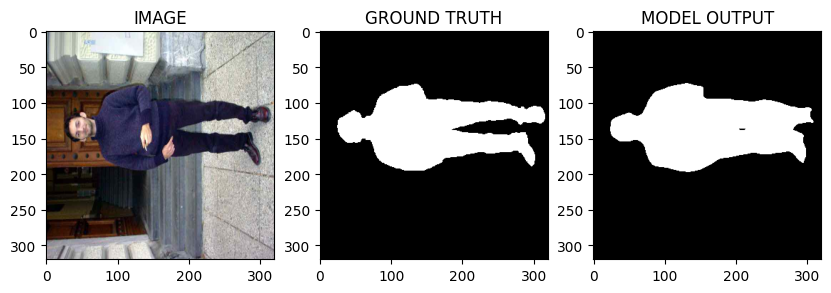

In [158]:
show_image_dataset(image, mask, pred_mask.squeeze(0))